## Assignment : 14

<pre>
1. Preprocess all the Data we have in DonorsChoose <a href='https://drive.google.com/drive/folders/1MIwK7BQMev8f5CbDDVNLPaFGB32pFN60'>Dataset</a> use train.csv
2. Combine 4 essay's into one column named - 'preprocessed_essays'. 
3. After step 2 you have to train 3 types of models as discussed below. 
4. For all the model use <a href='https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics'>'auc'</a> as a metric. check <a href='https://datascience.stackexchange.com/a/20192'>this</a> for using auc as a metric 
5. You are free to choose any number of layers/hiddden units but you have to use same type of architectures shown below. 
6. You can use any one of the optimizers and choice of Learning rate and momentum, resources: <a href='http://cs231n.github.io/neural-networks-3/'>cs231n class notes</a>, <a href='https://www.youtube.com/watch?v=hd_KFJ5ktUc'>cs231n class video</a>. 
7. For all the model's use <a href='https://www.youtube.com/watch?v=2U6Jl7oqRkM'>TensorBoard</a> and plot the Metric value and Loss with epoch. While submitting, take a screenshot of plots and include those images in .ipynb notebook and PDF. 
8. Use Categorical Cross Entropy as Loss to minimize.
</pre>

### Model-1

Build and Train deep neural network as shown below

<img src='https://i.imgur.com/w395Yk9.png'>
ref: https://i.imgur.com/w395Yk9.png

- __Input_seq_total_text_data__ --- You have to give Total text data columns. After this use the Embedding layer to get word vectors. Use given predefined glove word vectors, don't train any word vectors. After this use LSTM and get the LSTM output and Flatten that output. 
- __Input_school_state__ --- Give 'school_state' column as input to embedding layer and Train the Keras Embedding layer. 
- __Project_grade_category__  --- Give 'project_grade_category' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_categories__ --- Give 'input_clean_categories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_clean_subcategories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_teacher_prefix' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_remaining_teacher_number_of_previously_posted_projects._resource_summary_contains_numerical_digits._price._quantity__ ---concatenate remaining columns and add a Dense layer after that. 



- For LSTM, you can choose your sequence padding methods on your own or you can train your LSTM without padding, there is no restriction on that.

Below is an example of embedding layer for a categorical columns. In below code all are dummy values, we gave only for referance. 

In [ ]:
# https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work
input_layer = Input(shape=(n,))
embedding = Embedding(no_1, no_2, input_length=n)(input_layer)
flatten = Flatten()(embedding)

### 1. Go through this blog, if you have any doubt on using predefined Embedding values in Embedding layer - https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
### 2. Please go through this link https://keras.io/getting-started/functional-api-guide/ and check the 'Multi-input and multi-output models' then you will get to know how to give multiple inputs. 

### Model-2

Use the same model as above but for 'input_seq_total_text_data' give only some words in the sentance not all the words. Filter the words as below. 

<pre>
1. Train the TF-IDF on the Train data <br>
2. Get the idf value for each word we have in the train data. <br>
3. Remove the low idf value and high idf value words from our data. Do some analysis on the Idf values and based on those values choose the low and high threshold value. Because very frequent words and very very rare words don't give much information. (you can plot a box plots and take only the idf scores within IQR range and corresponding words)<br>
4. Train the LSTM after removing the Low and High idf value words. (In model-1 Train on total data but in Model-2 train on data after removing some words based on IDF values)
</pre>

### Model-3

<img src='https://i.imgur.com/fkQ8nGo.png'>
ref: https://i.imgur.com/fkQ8nGo.png


- __input_seq_total_text_data__: <br>
<pre>
    . Use text column('essay'), and use the Embedding layer to get word vectors. <br>
    . Use given predefined glove word vectors, don't train any word vectors. <br>
    . Use LSTM that is given above, get the LSTM output and Flatten that output. <br>
    . You are free to preprocess the input text as you needed. <br>
</pre>
- __Other_than_text_data__:<br>
<pre>
    . Convert all your Categorical values to onehot coded and then concatenate all these onehot vectors <br>
    . Neumerical values and use <a href='https://keras.io/getting-started/sequential-model-guide/#sequence-classification-with-1d-convolutions'>CNN1D</a> as shown in above figure. <br>
    . You are free to choose all CNN parameters like kernel sizes, stride.<br>
    
</pre>

In [54]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from keras.layers import Input
from keras.layers import Embedding
import re

import keras
from numpy import asarray
from time import time
import seaborn as sns

from tensorboard import *
from keras.utils import to_categorical
from keras.regularizers import l2
from keras.layers import LeakyReLU
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.python.keras.callbacks import TensorBoard
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

from nltk.corpus import stopwords
import pickle

from tqdm import tqdm
import os
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from numpy import zeros
from keras.layers import Input
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import LSTM,Bidirectional
from keras.layers.core import Dense, Dropout
from keras.models import Model, load_model
from keras.layers import Reshape,Concatenate
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from scipy.sparse import hstack
from keras.layers import Conv1D

import tensorflow as tf
import datetime
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import roc_auc_score
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers.merge import concatenate
from keras.callbacks import *

### Reading Data 

In [2]:
project_data = pd.read_csv('preprocessed_data.csv')

In [3]:
df = pd.read_csv('train_data.csv')

In [4]:
df.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved'],
      dtype='object')

In [5]:
df.id.dtype

dtype('O')

In [6]:
project_data['id'] = df['id'].astype(object)

In [7]:
project_data.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price', 'id'],
      dtype='object')

In [8]:
resource_data = pd.read_csv('resources.csv')

In [9]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 10)
--------------------------------------------------
The attributes of data : ['school_state' 'teacher_prefix' 'project_grade_category'
 'teacher_number_of_previously_posted_projects' 'project_is_approved'
 'clean_categories' 'clean_subcategories' 'essay' 'price' 'id']


In [10]:
print("Number of data points in resource data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in resource data (1541272, 4)
['id' 'description' 'quantity' 'price']


,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


In [11]:
resource_data.drop(['price'],axis=1,inplace=True)

In [12]:
resource_data.columns

Index(['id', 'description', 'quantity'], dtype='object')

In [13]:
price_data = resource_data.groupby('id').agg({'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [14]:
project_data.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price', 'id',
       'quantity'],
      dtype='object')

#### Preprocessing project title 

In [15]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [16]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [17]:
# similarly you can preprocess the titles also
preprocessed_titles = []
for sentance in tqdm(df['project_title'].values):
    sent = decontracted(sentance)
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_titles.append(sent.lower().strip())

100%|███████████████████████████████████████████████████████████████████████| 109248/109248 [00:05<00:00, 19144.90it/s]


In [18]:
df['project_title'].values

array(['Educational Support for English Learners at Home',
       'Wanted: Projector for Hungry Learners',
       'Soccer Equipment for AWESOME Middle School Students', ...,
       '2016/2017 Beginning of the Year Basics',
       'Flexible Seating in Inclusive Classroom',
       'Classroom Tech to Develop 21st Century Leaders'], dtype=object)

In [19]:
preprocessed_titles[4]

'interactive math tools'

In [20]:
df.project_title.dtype

dtype('O')

In [21]:
project_data['project_title'] = df['project_title'].astype(object)

In [22]:
project_data.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price', 'id',
       'quantity', 'project_title'],
      dtype='object')

In [23]:
clean_data=project_data.copy()
# Adding preprocessed_essays and titles to the dataframe
clean_data['clean_essay']=project_data['essay'].astype(object)
clean_data['clean_titles']=preprocessed_titles
clean_data.drop(['project_title'],axis=1,inplace=True)
y=clean_data['project_is_approved']
clean_data.drop(['project_is_approved'],axis=1, inplace=True)
x=clean_data

In [24]:
from sklearn.model_selection import train_test_split
X_train,x_test,Y_train,y_test=train_test_split(x,y,test_size=0.2,stratify=y)
x_train,x_cv,y_train,y_cv=train_test_split(X_train,Y_train,test_size=0.2,stratify=Y_train)

In [25]:
print(x_train.shape, y_train.shape)
print(x_cv.shape, y_cv.shape)
print(x_test.shape, y_test.shape)

(69918, 12) (69918,)
(17480, 12) (17480,)
(21850, 12) (21850,)


### Onehotencoding Categorical features 

In [26]:
#https://stackoverflow.com/questions/21057621/sklearn-labelencoder-with-never-seen-before-values

class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)


In [27]:
vectorizer = LabelEncoderExt()
vectorizer.fit(x_train['teacher_prefix'].values)
x_train_teacher_prefix = vectorizer.transform(x_train['teacher_prefix'].values)
x_cv_teacher_prefix = vectorizer.transform(x_cv['teacher_prefix'].values)
x_test_teacher_prefix = vectorizer.transform(x_test['teacher_prefix'].values)

vectorizer = LabelEncoderExt()
vectorizer.fit(x_train['school_state'].values)
x_train_state = vectorizer.transform(x_train['school_state'].values)
x_cv_state = vectorizer.transform(x_cv['school_state'].values)
x_test_state = vectorizer.transform(x_test['school_state'].values)

vectorizer = LabelEncoderExt()
vectorizer.fit(['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2'])
x_train_grade = vectorizer.transform(x_train['project_grade_category'].values)
x_cv_grade = vectorizer.transform(x_cv['project_grade_category'].values)
x_test_grade = vectorizer.transform(x_test['project_grade_category'].values)

vectorizer = LabelEncoderExt()
vectorizer.fit(x_train['clean_categories'].values)
x_train_cat = vectorizer.transform(x_train['clean_categories'].values)
x_cv_cat = vectorizer.transform(x_cv['clean_categories'].values)
x_test_cat = vectorizer.transform(x_test['clean_categories'].values)

vectorizer = LabelEncoderExt()
vectorizer.fit(x_train['clean_subcategories'].values)
x_train_scat = vectorizer.transform(x_train['clean_subcategories'].values)
x_cv_scat = vectorizer.transform(x_cv['clean_subcategories'].values)
x_test_scat = vectorizer.transform(x_test['clean_subcategories'].values)


### Embedding Categorical variables 

In [28]:
#https://medium.com/@davidheffernan_99410/an-introduction-to-using-categorical-embeddings-ee686ed7e7f9
category_variables = ["teacher_prefix","school_state","project_grade_category","clean_categories","clean_subcategories"]
category_sizes = {}
category_embsizes = {}
for cat in category_variables:
    category_sizes[cat] = x_train[cat].nunique()
    category_embsizes[cat] = min(50, category_sizes[cat]//2+1)

In [29]:
inputs = []
concat = []

In [30]:
for cat in category_variables:
    x = Input((1,), name=cat)
    inputs.append(x)
    x = Embedding(category_sizes[cat]+1, category_embsizes[cat], input_length=1)(x)
    x = Flatten()(x)
    concat.append(x)

W1022 12:19:29.139929 21840 deprecation_wrapper.py:119] From c:\users\acer\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1022 12:19:29.194906 21840 deprecation_wrapper.py:119] From c:\users\acer\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1022 12:19:29.234918 21840 deprecation_wrapper.py:119] From c:\users\acer\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



### Numerical Variables 

In [31]:
input_train = np.concatenate((x_train['quantity'].values.reshape(-1,1),x_train['price'].values.reshape(-1,1),x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)), axis=1)
input_cv = np.concatenate((x_cv['quantity'].values.reshape(-1,1),x_cv['price'].values.reshape(-1,1),x_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)), axis=1)
input_test = np.concatenate((x_test['quantity'].values.reshape(-1,1),x_test['price'].values.reshape(-1,1),x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)), axis=1)

In [32]:
print(input_train.shape, input_cv.shape, input_test.shape)

(69918, 3) (17480, 3) (21850, 3)


In [35]:
std_num = StandardScaler().fit(input_train)
input_train_norm = std_num.transform(input_train)
input_cv_norm = std_num.transform(input_cv)
input_test_norm = std_num.transform(input_test)

In [58]:
y_binary_train = to_categorical(y_train)
y_binary_cv = to_categorical(y_cv)
y_binary_test = to_categorical(y_test)

### Encoding Text Features

In [36]:
max_length=400

In [37]:
#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
def padded(encoded_docs):  
    max_length = 400
    padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
    return padded_docs

In [38]:
#https://stackoverflow.com/posts/51956230/revisions
t = Tokenizer()
t.fit_on_texts(x_train.clean_essay)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(x_train.clean_essay)
essay_padded_train = padded(encoded_docs)

In [39]:
encoded_docs = t.texts_to_sequences(x_cv.clean_essay)
essay_padded_cv = padded(encoded_docs)

In [40]:
encoded_docs = t.texts_to_sequences(x_test.clean_essay)
essay_padded_test = padded(encoded_docs)

In [41]:
print("encoded train data shape",essay_padded_train.shape)
print("encoded cv data shape",essay_padded_cv.shape)
print("encoded cv data shape",essay_padded_test.shape)

encoded train data shape (69918, 400)
encoded cv data shape (17480, 400)
encoded cv data shape (21850, 400)


In [42]:
embeddings_index = dict()
f = open('glove.6B.50d.txt', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [43]:
embedding_matrix = zeros((vocab_size, 50))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [44]:
print("embedding matrix shape",embedding_matrix.shape)

embedding matrix shape (47479, 50)


In [45]:
text_input = Input(shape=(max_length,), name = "text_input")
# max_length = 150 ---->max length of sentence
inputs.append(text_input)
e1 = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=max_length,trainable=False)(text_input)

l1= LSTM(128,kernel_initializer='glorot_normal',recurrent_dropout=0.5,kernel_regularizer=l2(0.001),return_sequences=True)(e1)
f1= Flatten()(l1)
concat.append(f1)

W1022 12:25:07.683505 21840 deprecation_wrapper.py:119] From c:\users\acer\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1022 12:25:07.683505 21840 deprecation_wrapper.py:119] From c:\users\acer\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W1022 12:25:08.355258 21840 deprecation.py:506] From c:\users\acer\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [46]:
input_layer_num =  Input(shape=(3,), name="input_layer_num")
inputs.append(input_layer_num)
input_dense_num = Dense(64, activation='relu',kernel_initializer='glorot_normal',kernel_regularizer=l2(0.001))(input_layer_num)
concat.append(input_dense_num)

### Model 1 

In [50]:
x = Concatenate()(concat)
x= Dense(512, activation='relu',kernel_regularizer=l2(0.01))(x)
#x=BatchNormalization()(x)
x= Dropout(0.4)(x)
#x= Dense(256,kernel_initializer='glorot_normal',kernel_regularizer=l2(0.001))(x)
x= Dense(512, activation='relu',kernel_regularizer=l2(0.01))(x)
x= Dropout(0.3)(x)
x= Dense(256, activation='relu',kernel_regularizer=l2(0.01))(x)
#x= Dense(128,kernel_initializer='glorot_normal',kernel_regularizer=l2(0.01))(x)
x= Dense(128, activation='relu',kernel_regularizer=l2(0.01))(x)
#x= Dense(64,kernel_initializer='glorot_normal',kernel_regularizer=l2(0.001))(x)

output=Dense(2, activation='softmax')(x)
model_1 = Model(inputs=inputs, outputs=output)

In [51]:
model_1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         (None, 400)          0                                            
__________________________________________________________________________________________________
teacher_prefix (InputLayer)     (None, 1)            0                                            
__________________________________________________________________________________________________
school_state (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
project_grade_category (InputLa (None, 1)            0                                            
__________________________________________________________________________________________________
clean_cate

In [52]:
#https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/
from keras.utils.vis_utils import plot_model
plot_model(model_1, to_file='model_4.png', show_shapes=True, show_layer_names=True)

<img src="model_4.png">

In [53]:
#https://stackoverflow.com/posts/51734992/revisions
def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [54]:
batch_size=128

In [69]:
model_1.compile(optimizer=tf.train.AdamOptimizer(), loss='categorical_crossentropy',metrics=['accuracy', auroc])

In [56]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir= log_dir)

In [59]:
history_1= model_1.fit({'text_input': essay_padded_train, 'school_state': x_train_state, 'project_grade_category': x_train_grade,'clean_categories': x_train_cat,'clean_subcategories':x_train_scat, 'teacher_prefix':x_train_teacher_prefix, 'input_layer_num':input_train},
          y_binary_train,
          epochs=15, batch_size=batch_size,verbose=1, validation_data=({'text_input': essay_padded_cv, 'school_state': x_cv_state, 'project_grade_category': x_cv_grade,'clean_categories': x_cv_cat,'clean_subcategories':x_cv_scat, 'teacher_prefix':x_cv_teacher_prefix, 'input_layer_num':input_cv},
          y_binary_cv),callbacks=[tensorboard])

W1022 12:28:58.944650 21840 deprecation.py:323] From c:\users\acer\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 69918 samples, validate on 17480 samples


W1022 12:29:04.048750 21840 deprecation_wrapper.py:119] From c:\users\acer\appdata\local\programs\python\python37\lib\site-packages\keras\callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W1022 12:29:04.048750 21840 deprecation_wrapper.py:119] From c:\users\acer\appdata\local\programs\python\python37\lib\site-packages\keras\callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/15


18432/69918 [======>.......................] - ETA: 1:19:25 - loss: 22.3441 - acc: 0.2109 - auroc: 0.423 - ETA: 52:02 - loss: 21.1386 - acc: 0.5469 - auroc: 0.4949  - ETA: 42:26 - loss: 20.1783 - acc: 0.6641 - auroc: 0.421 - ETA: 37:46 - loss: 19.4783 - acc: 0.7031 - auroc: 0.424 - ETA: 34:26 - loss: 18.5189 - acc: 0.7469 - auroc: 0.432 - ETA: 32:41 - loss: 17.8023 - acc: 0.7188 - auroc: 0.451 - ETA: 31:28 - loss: 17.1377 - acc: 0.7243 - auroc: 0.440 - ETA: 30:55 - loss: 16.6073 - acc: 0.7334 - auroc: 0.424 - ETA: 30:25 - loss: 16.0613 - acc: 0.7483 - auroc: 0.443 - ETA: 30:06 - loss: 15.6311 - acc: 0.7477 - auroc: 0.441 - ETA: 29:48 - loss: 15.2340 - acc: 0.7521 - auroc: 0.448 - ETA: 29:42 - loss: 14.8880 - acc: 0.7546 - auroc: 0.448 - ETA: 29:31 - loss: 14.5852 - acc: 0.7596 - auroc: 0.435 - ETA: 29:26 - loss: 14.2956 - acc: 0.7640 - auroc: 0.437 - ETA: 29:03 - loss: 14.0388 - acc: 0.7635 - auroc: 0.440 - ETA: 28:55 - loss: 13.8031 - acc: 0.7671 - auroc: 0.441 - ETA: 28:57 - loss: 13

18688/69918 [=======>......................] - ETA: 50:38 - loss: 0.6752 - acc: 0.7891 - auroc: 0.59 - ETA: 50:22 - loss: 0.6077 - acc: 0.8281 - auroc: 0.60 - ETA: 50:15 - loss: 0.6151 - acc: 0.8229 - auroc: 0.60 - ETA: 50:10 - loss: 0.5956 - acc: 0.8320 - auroc: 0.64 - ETA: 50:08 - loss: 0.5840 - acc: 0.8375 - auroc: 0.66 - ETA: 49:52 - loss: 0.5811 - acc: 0.8398 - auroc: 0.66 - ETA: 49:45 - loss: 0.5765 - acc: 0.8426 - auroc: 0.66 - ETA: 49:50 - loss: 0.5751 - acc: 0.8447 - auroc: 0.64 - ETA: 49:41 - loss: 0.5896 - acc: 0.8385 - auroc: 0.63 - ETA: 49:38 - loss: 0.5856 - acc: 0.8406 - auroc: 0.63 - ETA: 49:31 - loss: 0.5881 - acc: 0.8388 - auroc: 0.62 - ETA: 49:23 - loss: 0.5876 - acc: 0.8385 - auroc: 0.62 - ETA: 49:19 - loss: 0.5882 - acc: 0.8377 - auroc: 0.63 - ETA: 49:16 - loss: 0.5871 - acc: 0.8382 - auroc: 0.63 - ETA: 49:09 - loss: 0.5809 - acc: 0.8427 - auroc: 0.63 - ETA: 49:03 - loss: 0.5809 - acc: 0.8418 - auroc: 0.63 - ETA: 49:01 - loss: 0.5813 - acc: 0.8410 - auroc: 0.63 - E

69918/69918 [==============================] - ETA: 10:54 - loss: 0.4920 - acc: 0.8477 - auroc: 0.65 - ETA: 10:47 - loss: 0.4918 - acc: 0.8477 - auroc: 0.65 - ETA: 10:41 - loss: 0.4917 - acc: 0.8478 - auroc: 0.65 - ETA: 10:34 - loss: 0.4914 - acc: 0.8478 - auroc: 0.65 - ETA: 10:28 - loss: 0.4914 - acc: 0.8478 - auroc: 0.65 - ETA: 10:21 - loss: 0.4914 - acc: 0.8478 - auroc: 0.65 - ETA: 10:15 - loss: 0.4915 - acc: 0.8477 - auroc: 0.65 - ETA: 10:09 - loss: 0.4915 - acc: 0.8476 - auroc: 0.65 - ETA: 10:02 - loss: 0.4911 - acc: 0.8478 - auroc: 0.65 - ETA: 9:56 - loss: 0.4910 - acc: 0.8478 - auroc: 0.6550 - ETA: 9:49 - loss: 0.4911 - acc: 0.8478 - auroc: 0.654 - ETA: 9:43 - loss: 0.4909 - acc: 0.8478 - auroc: 0.654 - ETA: 9:36 - loss: 0.4908 - acc: 0.8479 - auroc: 0.654 - ETA: 9:30 - loss: 0.4908 - acc: 0.8478 - auroc: 0.654 - ETA: 9:23 - loss: 0.4907 - acc: 0.8478 - auroc: 0.654 - ETA: 9:17 - loss: 0.4909 - acc: 0.8477 - auroc: 0.654 - ETA: 9:11 - loss: 0.4908 - acc: 0.8477 - auroc: 0.654 - 

18688/69918 [=======>......................] - ETA: 37:31 - loss: 0.4676 - acc: 0.8594 - auroc: 0.51 - ETA: 38:27 - loss: 0.4899 - acc: 0.8438 - auroc: 0.55 - ETA: 39:08 - loss: 0.4848 - acc: 0.8490 - auroc: 0.57 - ETA: 38:47 - loss: 0.4676 - acc: 0.8633 - auroc: 0.59 - ETA: 39:14 - loss: 0.4640 - acc: 0.8656 - auroc: 0.59 - ETA: 39:01 - loss: 0.4644 - acc: 0.8633 - auroc: 0.60 - ETA: 38:53 - loss: 0.4697 - acc: 0.8594 - auroc: 0.59 - ETA: 39:07 - loss: 0.4777 - acc: 0.8555 - auroc: 0.58 - ETA: 38:52 - loss: 0.4708 - acc: 0.8585 - auroc: 0.58 - ETA: 38:43 - loss: 0.4663 - acc: 0.8586 - auroc: 0.61 - ETA: 38:41 - loss: 0.4684 - acc: 0.8572 - auroc: 0.60 - ETA: 38:47 - loss: 0.4593 - acc: 0.8613 - auroc: 0.61 - ETA: 38:35 - loss: 0.4616 - acc: 0.8594 - auroc: 0.61 - ETA: 38:30 - loss: 0.4777 - acc: 0.8521 - auroc: 0.60 - ETA: 38:14 - loss: 0.4731 - acc: 0.8536 - auroc: 0.61 - ETA: 38:06 - loss: 0.4774 - acc: 0.8511 - auroc: 0.60 - ETA: 38:08 - loss: 0.4767 - acc: 0.8511 - auroc: 0.60 - E

18688/69918 [=======>......................] - ETA: 19:43 - loss: 0.4382 - acc: 0.8438 - auroc: 0.67 - ETA: 20:31 - loss: 0.4440 - acc: 0.8398 - auroc: 0.67 - ETA: 20:28 - loss: 0.4445 - acc: 0.8411 - auroc: 0.66 - ETA: 20:28 - loss: 0.4489 - acc: 0.8457 - auroc: 0.61 - ETA: 20:22 - loss: 0.4467 - acc: 0.8422 - auroc: 0.64 - ETA: 20:20 - loss: 0.4365 - acc: 0.8477 - auroc: 0.65 - ETA: 20:17 - loss: 0.4396 - acc: 0.8449 - auroc: 0.65 - ETA: 20:13 - loss: 0.4361 - acc: 0.8457 - auroc: 0.66 - ETA: 20:10 - loss: 0.4371 - acc: 0.8446 - auroc: 0.66 - ETA: 20:12 - loss: 0.4344 - acc: 0.8453 - auroc: 0.67 - ETA: 20:08 - loss: 0.4321 - acc: 0.8473 - auroc: 0.67 - ETA: 20:06 - loss: 0.4256 - acc: 0.8509 - auroc: 0.67 - ETA: 20:04 - loss: 0.4298 - acc: 0.8486 - auroc: 0.67 - ETA: 20:02 - loss: 0.4310 - acc: 0.8488 - auroc: 0.66 - ETA: 20:00 - loss: 0.4336 - acc: 0.8469 - auroc: 0.67 - ETA: 19:57 - loss: 0.4309 - acc: 0.8486 - auroc: 0.67 - ETA: 19:54 - loss: 0.4304 - acc: 0.8488 - auroc: 0.67 - E

69918/69918 [==============================] - ETA: 4:02 - loss: 0.4333 - acc: 0.8495 - auroc: 0.650 - ETA: 4:00 - loss: 0.4335 - acc: 0.8494 - auroc: 0.650 - ETA: 3:57 - loss: 0.4335 - acc: 0.8494 - auroc: 0.650 - ETA: 3:55 - loss: 0.4335 - acc: 0.8494 - auroc: 0.650 - ETA: 3:53 - loss: 0.4335 - acc: 0.8494 - auroc: 0.650 - ETA: 3:51 - loss: 0.4335 - acc: 0.8494 - auroc: 0.650 - ETA: 3:48 - loss: 0.4336 - acc: 0.8493 - auroc: 0.650 - ETA: 3:46 - loss: 0.4335 - acc: 0.8494 - auroc: 0.650 - ETA: 3:44 - loss: 0.4337 - acc: 0.8492 - auroc: 0.650 - ETA: 3:42 - loss: 0.4338 - acc: 0.8492 - auroc: 0.650 - ETA: 3:39 - loss: 0.4336 - acc: 0.8492 - auroc: 0.651 - ETA: 3:37 - loss: 0.4337 - acc: 0.8492 - auroc: 0.650 - ETA: 3:35 - loss: 0.4337 - acc: 0.8492 - auroc: 0.650 - ETA: 3:33 - loss: 0.4338 - acc: 0.8492 - auroc: 0.650 - ETA: 3:30 - loss: 0.4337 - acc: 0.8492 - auroc: 0.650 - ETA: 3:28 - loss: 0.4337 - acc: 0.8492 - auroc: 0.650 - ETA: 3:26 - loss: 0.4338 - acc: 0.8491 - auroc: 0.650 - E

18688/69918 [=======>......................] - ETA: 19:35 - loss: 0.3765 - acc: 0.8828 - auroc: 0.60 - ETA: 19:48 - loss: 0.3670 - acc: 0.8867 - auroc: 0.61 - ETA: 19:54 - loss: 0.3877 - acc: 0.8750 - auroc: 0.61 - ETA: 19:55 - loss: 0.3887 - acc: 0.8750 - auroc: 0.61 - ETA: 19:59 - loss: 0.4063 - acc: 0.8656 - auroc: 0.62 - ETA: 20:06 - loss: 0.4038 - acc: 0.8672 - auroc: 0.62 - ETA: 20:04 - loss: 0.4089 - acc: 0.8650 - auroc: 0.62 - ETA: 20:01 - loss: 0.4128 - acc: 0.8613 - auroc: 0.64 - ETA: 19:59 - loss: 0.4195 - acc: 0.8568 - auroc: 0.64 - ETA: 19:56 - loss: 0.4146 - acc: 0.8594 - auroc: 0.65 - ETA: 19:53 - loss: 0.4212 - acc: 0.8565 - auroc: 0.64 - ETA: 19:52 - loss: 0.4205 - acc: 0.8574 - auroc: 0.63 - ETA: 19:50 - loss: 0.4174 - acc: 0.8600 - auroc: 0.62 - ETA: 19:47 - loss: 0.4224 - acc: 0.8566 - auroc: 0.63 - ETA: 19:46 - loss: 0.4221 - acc: 0.8562 - auroc: 0.63 - ETA: 19:45 - loss: 0.4174 - acc: 0.8589 - auroc: 0.64 - ETA: 19:43 - loss: 0.4196 - acc: 0.8575 - auroc: 0.64 - E

18688/69918 [=======>......................] - ETA: 19:52 - loss: 0.4590 - acc: 0.8359 - auroc: 0.64 - ETA: 19:58 - loss: 0.4588 - acc: 0.8398 - auroc: 0.62 - ETA: 19:59 - loss: 0.4415 - acc: 0.8438 - auroc: 0.67 - ETA: 20:02 - loss: 0.4393 - acc: 0.8438 - auroc: 0.68 - ETA: 20:08 - loss: 0.4337 - acc: 0.8500 - auroc: 0.67 - ETA: 20:12 - loss: 0.4424 - acc: 0.8438 - auroc: 0.67 - ETA: 20:10 - loss: 0.4417 - acc: 0.8460 - auroc: 0.66 - ETA: 20:10 - loss: 0.4436 - acc: 0.8447 - auroc: 0.66 - ETA: 20:04 - loss: 0.4479 - acc: 0.8429 - auroc: 0.66 - ETA: 20:02 - loss: 0.4422 - acc: 0.8461 - auroc: 0.66 - ETA: 20:03 - loss: 0.4470 - acc: 0.8430 - auroc: 0.66 - ETA: 20:00 - loss: 0.4472 - acc: 0.8431 - auroc: 0.66 - ETA: 19:58 - loss: 0.4479 - acc: 0.8431 - auroc: 0.65 - ETA: 19:56 - loss: 0.4456 - acc: 0.8449 - auroc: 0.65 - ETA: 19:54 - loss: 0.4444 - acc: 0.8448 - auroc: 0.66 - ETA: 19:52 - loss: 0.4439 - acc: 0.8447 - auroc: 0.66 - ETA: 19:49 - loss: 0.4387 - acc: 0.8474 - auroc: 0.66 - E

69918/69918 [==============================] - ETA: 4:02 - loss: 0.4328 - acc: 0.8488 - auroc: 0.685 - ETA: 4:00 - loss: 0.4330 - acc: 0.8487 - auroc: 0.685 - ETA: 3:58 - loss: 0.4328 - acc: 0.8488 - auroc: 0.685 - ETA: 3:55 - loss: 0.4329 - acc: 0.8487 - auroc: 0.685 - ETA: 3:53 - loss: 0.4329 - acc: 0.8487 - auroc: 0.685 - ETA: 3:51 - loss: 0.4329 - acc: 0.8487 - auroc: 0.685 - ETA: 3:49 - loss: 0.4329 - acc: 0.8486 - auroc: 0.685 - ETA: 3:46 - loss: 0.4330 - acc: 0.8486 - auroc: 0.685 - ETA: 3:44 - loss: 0.4331 - acc: 0.8485 - auroc: 0.685 - ETA: 3:42 - loss: 0.4332 - acc: 0.8484 - auroc: 0.685 - ETA: 3:40 - loss: 0.4333 - acc: 0.8484 - auroc: 0.685 - ETA: 3:37 - loss: 0.4333 - acc: 0.8483 - auroc: 0.685 - ETA: 3:35 - loss: 0.4334 - acc: 0.8483 - auroc: 0.685 - ETA: 3:33 - loss: 0.4335 - acc: 0.8483 - auroc: 0.685 - ETA: 3:31 - loss: 0.4333 - acc: 0.8484 - auroc: 0.685 - ETA: 3:28 - loss: 0.4330 - acc: 0.8485 - auroc: 0.685 - ETA: 3:26 - loss: 0.4331 - acc: 0.8485 - auroc: 0.685 - E

18688/69918 [=======>......................] - ETA: 53:02 - loss: 0.4807 - acc: 0.8281 - auroc: 0.63 - ETA: 52:26 - loss: 0.4345 - acc: 0.8477 - auroc: 0.70 - ETA: 52:27 - loss: 0.4562 - acc: 0.8281 - auroc: 0.71 - ETA: 51:57 - loss: 0.4531 - acc: 0.8320 - auroc: 0.71 - ETA: 51:43 - loss: 0.4410 - acc: 0.8359 - auroc: 0.72 - ETA: 51:36 - loss: 0.4250 - acc: 0.8477 - auroc: 0.72 - ETA: 51:21 - loss: 0.4193 - acc: 0.8504 - auroc: 0.73 - ETA: 51:18 - loss: 0.4217 - acc: 0.8486 - auroc: 0.73 - ETA: 51:14 - loss: 0.4384 - acc: 0.8438 - auroc: 0.72 - ETA: 51:10 - loss: 0.4339 - acc: 0.8477 - auroc: 0.71 - ETA: 51:06 - loss: 0.4286 - acc: 0.8487 - auroc: 0.72 - ETA: 50:59 - loss: 0.4279 - acc: 0.8490 - auroc: 0.72 - ETA: 50:50 - loss: 0.4252 - acc: 0.8516 - auroc: 0.72 - ETA: 50:44 - loss: 0.4237 - acc: 0.8516 - auroc: 0.73 - ETA: 50:36 - loss: 0.4256 - acc: 0.8505 - auroc: 0.72 - ETA: 50:28 - loss: 0.4256 - acc: 0.8511 - auroc: 0.72 - ETA: 50:18 - loss: 0.4243 - acc: 0.8520 - auroc: 0.72 - E

18688/69918 [=======>......................] - ETA: 52:12 - loss: 0.3384 - acc: 0.9141 - auroc: 0.68 - ETA: 51:32 - loss: 0.3497 - acc: 0.9023 - auroc: 0.69 - ETA: 51:21 - loss: 0.3805 - acc: 0.8802 - auroc: 0.71 - ETA: 50:58 - loss: 0.3837 - acc: 0.8789 - auroc: 0.70 - ETA: 50:54 - loss: 0.3848 - acc: 0.8781 - auroc: 0.71 - ETA: 50:50 - loss: 0.4035 - acc: 0.8698 - auroc: 0.70 - ETA: 50:43 - loss: 0.4154 - acc: 0.8650 - auroc: 0.69 - ETA: 50:45 - loss: 0.4100 - acc: 0.8652 - auroc: 0.70 - ETA: 50:36 - loss: 0.4131 - acc: 0.8611 - auroc: 0.71 - ETA: 50:35 - loss: 0.4065 - acc: 0.8664 - auroc: 0.71 - ETA: 50:29 - loss: 0.4079 - acc: 0.8643 - auroc: 0.72 - ETA: 50:22 - loss: 0.4099 - acc: 0.8626 - auroc: 0.72 - ETA: 50:19 - loss: 0.4143 - acc: 0.8600 - auroc: 0.71 - ETA: 50:14 - loss: 0.4116 - acc: 0.8616 - auroc: 0.71 - ETA: 50:10 - loss: 0.4096 - acc: 0.8609 - auroc: 0.72 - ETA: 50:06 - loss: 0.4116 - acc: 0.8599 - auroc: 0.72 - ETA: 50:00 - loss: 0.4113 - acc: 0.8608 - auroc: 0.71 - E

69918/69918 [==============================] - ETA: 10:06 - loss: 0.4282 - acc: 0.8490 - auroc: 0.70 - ETA: 10:00 - loss: 0.4283 - acc: 0.8490 - auroc: 0.70 - ETA: 9:54 - loss: 0.4284 - acc: 0.8489 - auroc: 0.7007 - ETA: 9:49 - loss: 0.4284 - acc: 0.8489 - auroc: 0.700 - ETA: 9:43 - loss: 0.4286 - acc: 0.8488 - auroc: 0.700 - ETA: 9:37 - loss: 0.4286 - acc: 0.8488 - auroc: 0.700 - ETA: 9:32 - loss: 0.4288 - acc: 0.8487 - auroc: 0.700 - ETA: 9:26 - loss: 0.4286 - acc: 0.8489 - auroc: 0.700 - ETA: 9:20 - loss: 0.4287 - acc: 0.8488 - auroc: 0.700 - ETA: 9:15 - loss: 0.4286 - acc: 0.8489 - auroc: 0.700 - ETA: 9:09 - loss: 0.4285 - acc: 0.8489 - auroc: 0.700 - ETA: 9:03 - loss: 0.4285 - acc: 0.8489 - auroc: 0.700 - ETA: 8:58 - loss: 0.4286 - acc: 0.8488 - auroc: 0.700 - ETA: 8:52 - loss: 0.4285 - acc: 0.8488 - auroc: 0.700 - ETA: 8:46 - loss: 0.4287 - acc: 0.8487 - auroc: 0.700 - ETA: 8:41 - loss: 0.4284 - acc: 0.8488 - auroc: 0.700 - ETA: 8:35 - loss: 0.4285 - acc: 0.8488 - auroc: 0.700 - 

18688/69918 [=======>......................] - ETA: 53:30 - loss: 0.4309 - acc: 0.8594 - auroc: 0.67 - ETA: 52:46 - loss: 0.4882 - acc: 0.8242 - auroc: 0.61 - ETA: 52:31 - loss: 0.4932 - acc: 0.8203 - auroc: 0.60 - ETA: 52:11 - loss: 0.4937 - acc: 0.8184 - auroc: 0.60 - ETA: 51:47 - loss: 0.4914 - acc: 0.8187 - auroc: 0.59 - ETA: 51:32 - loss: 0.4834 - acc: 0.8216 - auroc: 0.60 - ETA: 51:26 - loss: 0.4774 - acc: 0.8259 - auroc: 0.59 - ETA: 51:13 - loss: 0.4657 - acc: 0.8330 - auroc: 0.59 - ETA: 51:09 - loss: 0.4695 - acc: 0.8316 - auroc: 0.59 - ETA: 51:04 - loss: 0.4735 - acc: 0.8266 - auroc: 0.60 - ETA: 51:00 - loss: 0.4640 - acc: 0.8303 - auroc: 0.62 - ETA: 50:55 - loss: 0.4701 - acc: 0.8268 - auroc: 0.62 - ETA: 50:51 - loss: 0.4647 - acc: 0.8305 - auroc: 0.62 - ETA: 50:44 - loss: 0.4674 - acc: 0.8281 - auroc: 0.62 - ETA: 50:38 - loss: 0.4661 - acc: 0.8292 - auroc: 0.62 - ETA: 50:37 - loss: 0.4622 - acc: 0.8311 - auroc: 0.62 - ETA: 50:27 - loss: 0.4556 - acc: 0.8359 - auroc: 0.62 - E

18688/69918 [=======>......................] - ETA: 53:56 - loss: 0.3671 - acc: 0.8828 - auroc: 0.74 - ETA: 52:43 - loss: 0.4109 - acc: 0.8672 - auroc: 0.70 - ETA: 52:20 - loss: 0.4267 - acc: 0.8646 - auroc: 0.69 - ETA: 52:22 - loss: 0.4202 - acc: 0.8691 - auroc: 0.69 - ETA: 52:20 - loss: 0.4208 - acc: 0.8688 - auroc: 0.70 - ETA: 52:13 - loss: 0.4286 - acc: 0.8672 - auroc: 0.68 - ETA: 52:06 - loss: 0.4206 - acc: 0.8717 - auroc: 0.68 - ETA: 52:05 - loss: 0.4243 - acc: 0.8672 - auroc: 0.69 - ETA: 51:56 - loss: 0.4203 - acc: 0.8698 - auroc: 0.68 - ETA: 51:49 - loss: 0.4202 - acc: 0.8672 - auroc: 0.69 - ETA: 51:44 - loss: 0.4259 - acc: 0.8643 - auroc: 0.69 - ETA: 51:40 - loss: 0.4176 - acc: 0.8685 - auroc: 0.69 - ETA: 51:32 - loss: 0.4156 - acc: 0.8684 - auroc: 0.70 - ETA: 51:25 - loss: 0.4129 - acc: 0.8694 - auroc: 0.70 - ETA: 51:21 - loss: 0.4080 - acc: 0.8703 - auroc: 0.70 - ETA: 51:15 - loss: 0.4103 - acc: 0.8682 - auroc: 0.71 - ETA: 51:11 - loss: 0.4097 - acc: 0.8686 - auroc: 0.70 - E

69918/69918 [==============================] - ETA: 10:00 - loss: 0.4249 - acc: 0.8494 - auroc: 0.70 - ETA: 9:53 - loss: 0.4248 - acc: 0.8494 - auroc: 0.7008 - ETA: 9:47 - loss: 0.4247 - acc: 0.8495 - auroc: 0.700 - ETA: 9:41 - loss: 0.4246 - acc: 0.8495 - auroc: 0.700 - ETA: 9:34 - loss: 0.4244 - acc: 0.8496 - auroc: 0.701 - ETA: 9:28 - loss: 0.4243 - acc: 0.8497 - auroc: 0.700 - ETA: 9:22 - loss: 0.4245 - acc: 0.8496 - auroc: 0.700 - ETA: 9:16 - loss: 0.4247 - acc: 0.8494 - auroc: 0.701 - ETA: 9:09 - loss: 0.4247 - acc: 0.8494 - auroc: 0.701 - ETA: 9:03 - loss: 0.4248 - acc: 0.8493 - auroc: 0.701 - ETA: 8:57 - loss: 0.4247 - acc: 0.8494 - auroc: 0.701 - ETA: 8:51 - loss: 0.4246 - acc: 0.8495 - auroc: 0.701 - ETA: 8:45 - loss: 0.4245 - acc: 0.8495 - auroc: 0.701 - ETA: 8:39 - loss: 0.4245 - acc: 0.8495 - auroc: 0.701 - ETA: 8:32 - loss: 0.4247 - acc: 0.8493 - auroc: 0.701 - ETA: 8:26 - loss: 0.4248 - acc: 0.8493 - auroc: 0.701 - ETA: 8:20 - loss: 0.4251 - acc: 0.8492 - auroc: 0.701 - 

18688/69918 [=======>......................] - ETA: 21:08 - loss: 0.5381 - acc: 0.7891 - auroc: 0.67 - ETA: 22:01 - loss: 0.4858 - acc: 0.8242 - auroc: 0.62 - ETA: 22:29 - loss: 0.4557 - acc: 0.8385 - auroc: 0.65 - ETA: 22:22 - loss: 0.4421 - acc: 0.8457 - auroc: 0.66 - ETA: 22:22 - loss: 0.4446 - acc: 0.8453 - auroc: 0.66 - ETA: 22:13 - loss: 0.4409 - acc: 0.8464 - auroc: 0.66 - ETA: 22:06 - loss: 0.4477 - acc: 0.8449 - auroc: 0.65 - ETA: 22:00 - loss: 0.4392 - acc: 0.8486 - auroc: 0.66 - ETA: 21:54 - loss: 0.4311 - acc: 0.8524 - auroc: 0.67 - ETA: 21:50 - loss: 0.4216 - acc: 0.8570 - auroc: 0.67 - ETA: 21:46 - loss: 0.4207 - acc: 0.8565 - auroc: 0.67 - ETA: 21:41 - loss: 0.4237 - acc: 0.8542 - auroc: 0.67 - ETA: 21:38 - loss: 0.4232 - acc: 0.8540 - auroc: 0.67 - ETA: 21:35 - loss: 0.4167 - acc: 0.8560 - auroc: 0.67 - ETA: 21:34 - loss: 0.4187 - acc: 0.8542 - auroc: 0.68 - ETA: 21:32 - loss: 0.4197 - acc: 0.8535 - auroc: 0.68 - ETA: 21:28 - loss: 0.4231 - acc: 0.8520 - auroc: 0.68 - E

18688/69918 [=======>......................] - ETA: 21:25 - loss: 0.3577 - acc: 0.8906 - auroc: 0.64 - ETA: 22:14 - loss: 0.3885 - acc: 0.8711 - auroc: 0.68 - ETA: 22:09 - loss: 0.3800 - acc: 0.8724 - auroc: 0.71 - ETA: 22:03 - loss: 0.4017 - acc: 0.8555 - auroc: 0.72 - ETA: 22:00 - loss: 0.4120 - acc: 0.8547 - auroc: 0.69 - ETA: 21:55 - loss: 0.4092 - acc: 0.8581 - auroc: 0.68 - ETA: 21:52 - loss: 0.4205 - acc: 0.8482 - auroc: 0.70 - ETA: 21:48 - loss: 0.4158 - acc: 0.8516 - auroc: 0.70 - ETA: 21:48 - loss: 0.4135 - acc: 0.8524 - auroc: 0.71 - ETA: 21:45 - loss: 0.4128 - acc: 0.8539 - auroc: 0.70 - ETA: 21:42 - loss: 0.4088 - acc: 0.8558 - auroc: 0.70 - ETA: 21:41 - loss: 0.4086 - acc: 0.8548 - auroc: 0.71 - ETA: 21:38 - loss: 0.4110 - acc: 0.8546 - auroc: 0.70 - ETA: 21:34 - loss: 0.4110 - acc: 0.8549 - auroc: 0.70 - ETA: 21:30 - loss: 0.4159 - acc: 0.8521 - auroc: 0.70 - ETA: 21:26 - loss: 0.4131 - acc: 0.8530 - auroc: 0.71 - ETA: 21:25 - loss: 0.4096 - acc: 0.8552 - auroc: 0.71 - E

69918/69918 [==============================] - ETA: 4:22 - loss: 0.4188 - acc: 0.8492 - auroc: 0.707 - ETA: 4:19 - loss: 0.4190 - acc: 0.8491 - auroc: 0.707 - ETA: 4:17 - loss: 0.4190 - acc: 0.8491 - auroc: 0.707 - ETA: 4:14 - loss: 0.4191 - acc: 0.8490 - auroc: 0.707 - ETA: 4:12 - loss: 0.4193 - acc: 0.8488 - auroc: 0.707 - ETA: 4:09 - loss: 0.4194 - acc: 0.8488 - auroc: 0.707 - ETA: 4:07 - loss: 0.4193 - acc: 0.8488 - auroc: 0.707 - ETA: 4:05 - loss: 0.4194 - acc: 0.8487 - auroc: 0.707 - ETA: 4:02 - loss: 0.4193 - acc: 0.8487 - auroc: 0.707 - ETA: 4:00 - loss: 0.4194 - acc: 0.8486 - auroc: 0.707 - ETA: 3:57 - loss: 0.4195 - acc: 0.8487 - auroc: 0.707 - ETA: 3:55 - loss: 0.4195 - acc: 0.8487 - auroc: 0.707 - ETA: 3:52 - loss: 0.4197 - acc: 0.8485 - auroc: 0.707 - ETA: 3:50 - loss: 0.4196 - acc: 0.8486 - auroc: 0.707 - ETA: 3:47 - loss: 0.4196 - acc: 0.8486 - auroc: 0.707 - ETA: 3:45 - loss: 0.4196 - acc: 0.8485 - auroc: 0.707 - ETA: 3:43 - loss: 0.4197 - acc: 0.8485 - auroc: 0.707 - E

18688/69918 [=======>......................] - ETA: 21:17 - loss: 0.5512 - acc: 0.7734 - auroc: 0.61 - ETA: 22:01 - loss: 0.5285 - acc: 0.7969 - auroc: 0.57 - ETA: 21:55 - loss: 0.4980 - acc: 0.8151 - auroc: 0.60 - ETA: 21:52 - loss: 0.4933 - acc: 0.8125 - auroc: 0.64 - ETA: 21:48 - loss: 0.4857 - acc: 0.8156 - auroc: 0.65 - ETA: 21:48 - loss: 0.4795 - acc: 0.8177 - auroc: 0.66 - ETA: 21:50 - loss: 0.4845 - acc: 0.8158 - auroc: 0.65 - ETA: 21:43 - loss: 0.4758 - acc: 0.8213 - auroc: 0.65 - ETA: 21:34 - loss: 0.4684 - acc: 0.8273 - auroc: 0.63 - ETA: 21:28 - loss: 0.4574 - acc: 0.8328 - auroc: 0.64 - ETA: 21:23 - loss: 0.4554 - acc: 0.8331 - auroc: 0.65 - ETA: 21:19 - loss: 0.4520 - acc: 0.8353 - auroc: 0.64 - ETA: 21:13 - loss: 0.4492 - acc: 0.8371 - auroc: 0.64 - ETA: 21:10 - loss: 0.4529 - acc: 0.8337 - auroc: 0.65 - ETA: 21:05 - loss: 0.4558 - acc: 0.8323 - auroc: 0.65 - ETA: 21:02 - loss: 0.4542 - acc: 0.8340 - auroc: 0.64 - ETA: 20:59 - loss: 0.4572 - acc: 0.8323 - auroc: 0.64 - E

18688/69918 [=======>......................] - ETA: 21:26 - loss: 0.3734 - acc: 0.8594 - auroc: 0.82 - ETA: 21:40 - loss: 0.3817 - acc: 0.8555 - auroc: 0.79 - ETA: 21:44 - loss: 0.3593 - acc: 0.8620 - auroc: 0.83 - ETA: 21:48 - loss: 0.3741 - acc: 0.8594 - auroc: 0.80 - ETA: 21:45 - loss: 0.3529 - acc: 0.8750 - auroc: 0.78 - ETA: 21:46 - loss: 0.3646 - acc: 0.8711 - auroc: 0.77 - ETA: 21:45 - loss: 0.3652 - acc: 0.8705 - auroc: 0.76 - ETA: 21:43 - loss: 0.3703 - acc: 0.8662 - auroc: 0.76 - ETA: 21:42 - loss: 0.3836 - acc: 0.8594 - auroc: 0.75 - ETA: 21:40 - loss: 0.3807 - acc: 0.8594 - auroc: 0.76 - ETA: 21:37 - loss: 0.3809 - acc: 0.8601 - auroc: 0.75 - ETA: 21:36 - loss: 0.3858 - acc: 0.8568 - auroc: 0.75 - ETA: 21:34 - loss: 0.3877 - acc: 0.8558 - auroc: 0.75 - ETA: 21:31 - loss: 0.3895 - acc: 0.8538 - auroc: 0.75 - ETA: 21:29 - loss: 0.3863 - acc: 0.8562 - auroc: 0.75 - ETA: 21:27 - loss: 0.3896 - acc: 0.8550 - auroc: 0.75 - ETA: 21:24 - loss: 0.3905 - acc: 0.8548 - auroc: 0.74 - E

69918/69918 [==============================] - ETA: 9:04 - loss: 0.4160 - acc: 0.8490 - auroc: 0.711 - ETA: 9:00 - loss: 0.4161 - acc: 0.8490 - auroc: 0.711 - ETA: 8:55 - loss: 0.4162 - acc: 0.8489 - auroc: 0.711 - ETA: 8:50 - loss: 0.4161 - acc: 0.8490 - auroc: 0.711 - ETA: 8:45 - loss: 0.4161 - acc: 0.8490 - auroc: 0.711 - ETA: 8:41 - loss: 0.4161 - acc: 0.8490 - auroc: 0.711 - ETA: 8:36 - loss: 0.4161 - acc: 0.8490 - auroc: 0.711 - ETA: 8:31 - loss: 0.4162 - acc: 0.8489 - auroc: 0.711 - ETA: 8:26 - loss: 0.4162 - acc: 0.8489 - auroc: 0.711 - ETA: 8:21 - loss: 0.4165 - acc: 0.8487 - auroc: 0.711 - ETA: 8:16 - loss: 0.4163 - acc: 0.8488 - auroc: 0.711 - ETA: 8:12 - loss: 0.4163 - acc: 0.8488 - auroc: 0.711 - ETA: 8:07 - loss: 0.4163 - acc: 0.8488 - auroc: 0.711 - ETA: 8:02 - loss: 0.4165 - acc: 0.8487 - auroc: 0.711 - ETA: 7:57 - loss: 0.4164 - acc: 0.8487 - auroc: 0.711 - ETA: 7:52 - loss: 0.4162 - acc: 0.8488 - auroc: 0.712 - ETA: 7:47 - loss: 0.4163 - acc: 0.8488 - auroc: 0.711 - E

18688/69918 [=======>......................] - ETA: 1:00:19 - loss: 0.4365 - acc: 0.8281 - auroc: 0.72 - ETA: 59:00 - loss: 0.4635 - acc: 0.8320 - auroc: 0.6506 - ETA: 58:52 - loss: 0.4440 - acc: 0.8411 - auroc: 0.67 - ETA: 58:47 - loss: 0.4296 - acc: 0.8477 - auroc: 0.69 - ETA: 58:18 - loss: 0.4126 - acc: 0.8547 - auroc: 0.71 - ETA: 58:09 - loss: 0.4164 - acc: 0.8503 - auroc: 0.72 - ETA: 58:03 - loss: 0.4214 - acc: 0.8482 - auroc: 0.71 - ETA: 57:59 - loss: 0.4224 - acc: 0.8457 - auroc: 0.72 - ETA: 57:50 - loss: 0.4264 - acc: 0.8464 - auroc: 0.71 - ETA: 57:38 - loss: 0.4299 - acc: 0.8445 - auroc: 0.71 - ETA: 57:31 - loss: 0.4230 - acc: 0.8487 - auroc: 0.71 - ETA: 57:23 - loss: 0.4265 - acc: 0.8477 - auroc: 0.70 - ETA: 57:16 - loss: 0.4314 - acc: 0.8456 - auroc: 0.70 - ETA: 57:10 - loss: 0.4294 - acc: 0.8460 - auroc: 0.70 - ETA: 57:04 - loss: 0.4258 - acc: 0.8495 - auroc: 0.70 - ETA: 56:57 - loss: 0.4271 - acc: 0.8477 - auroc: 0.70 - ETA: 56:49 - loss: 0.4292 - acc: 0.8456 - auroc: 0.70

In [74]:
print("val_auroc of test data : ", 0.7162)

val_auroc of test data :  0.7162


In [76]:
%matplotlib notebook
%matplotlib inline

In [77]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

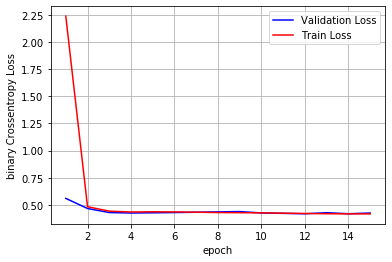

In [79]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('binary Crossentropy Loss')

# list of epoch numbers
x = list(range(1,15+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs


vy = history_1.history['val_loss']
ty = history_1.history['loss']
plt_dynamic(x, vy, ty, ax)

In [80]:
def plt_dynamic_auc(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation auc")
    ax.plot(x, ty, 'r', label="Train auc")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

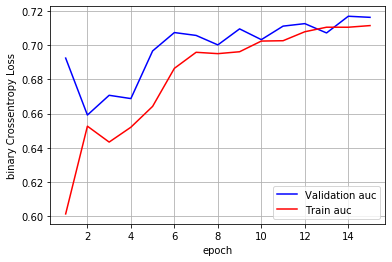

In [81]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('auc')

# list of epoch numbers
x = list(range(1,15+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs


vy = history_1.history['val_auroc']
ty = history_1.history['auroc']
plt_dynamic_auc(x, vy, ty, ax)

### Model 2 

In [65]:
vectorizer = TfidfVectorizer(min_df=10,max_features=10000) #Defining TFIDF with min_df=10
tf_v = vectorizer.fit(x_train.clean_essay)

In [66]:
idf_values = vectorizer.idf_ 

In [67]:
df = pd.DataFrame(idf_values, columns= ["idf"])
df.head()

,idf
0,7.178359
1,5.944493
2,4.476766
3,3.801596
4,7.171486


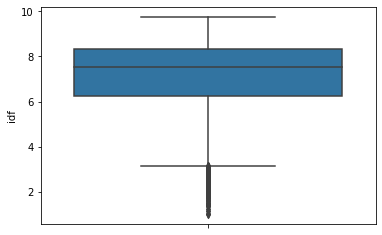

In [68]:
sns.boxplot(y = "idf", data = df )

In [69]:
#calculating speed values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =idf_values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 1.007882931788298
10 percentile value is 4.961406889772533
20 percentile value is 5.878449218826001
30 percentile value is 6.594411077152118
40 percentile value is 7.118140105754016
50 percentile value is 7.5399721913263855
60 percentile value is 7.89241283112633
70 percentile value is 8.203848989586218
80 percentile value is 8.491531062038
90 percentile value is 8.75389532650549
100 percentile value is  9.757197435369275


In [33]:
for i in range(0,100,5):
    var =idf_values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 1.007882931788298
5 percentile value is 4.107903145997144
10 percentile value is 4.961406889772533
15 percentile value is 5.465493438988679
20 percentile value is 5.878449218826001
25 percentile value is 6.266214749834764
30 percentile value is 6.594411077152118
35 percentile value is 6.86682567747311
40 percentile value is 7.118140105754016
45 percentile value is 7.342908352795227
50 percentile value is 7.5399721913263855
55 percentile value is 7.724275909324332
60 percentile value is 7.89241283112633
65 percentile value is 8.044218843994333
70 percentile value is 8.203848989586218
75 percentile value is 8.348430218397326
80 percentile value is 8.491531062038
85 percentile value is 8.628732183551485
90 percentile value is 8.75389532650549
95 percentile value is 8.896996170146164
100 percentile value is  9.757197435369275


In [34]:
features = vectorizer.get_feature_names()
sorted_idf = np.argsort(idf_values)[::-1]

In [35]:
len(features)

10000

In [36]:
sorted_idf

array([3950, 1619,  284, ..., 7840, 5912, 8648], dtype=int64)

In [37]:
imp_words = {features[e] for  e in sorted_idf[3000:8500]}

In [38]:
not_imp_words = []
for word in features:
    if word not in imp_words:
        not_imp_words.append(word)

In [39]:
def remove_words_with_idfValue(sentences):
    processed = []
    for sent in tqdm(sentences):
        sent = ' '.join(e for e in sent.split() if e not in not_imp_words)
        processed.append(sent)
    return processed

In [40]:
x_train_idf = remove_words_with_idfValue(x_train.clean_essay)
x_cv_idf = remove_words_with_idfValue(x_cv.clean_essay)
x_test_idf = remove_words_with_idfValue(x_test.clean_essay)

100%|████████████████████████████████████████████████████████████████████████████| 21850/21850 [04:42<00:00, 77.37it/s]


In [41]:
max_length = 400

In [42]:
#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
def padded(encoded_docs):  
    max_length = 400
    padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
    return padded_docs

In [43]:
#https://stackoverflow.com/posts/51956230/revisions
t = Tokenizer()
t.fit_on_texts(x_train_idf)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(x_train_idf)
essay_padded_train = padded(encoded_docs)

In [44]:
#t = Tokenizer()
#t.fit_on_texts(x_cross_imp)
#vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(x_cv_idf)
essay_padded_cv = padded(encoded_docs)

In [45]:
#t = Tokenizer()
#t.fit_on_texts(x_test_imp)
# vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(x_test_idf)
essay_padded_test = padded(encoded_docs)

In [46]:
print("encoded train data shape",essay_padded_train.shape)
print("encoded cv data shape",essay_padded_cv.shape)
print("encoded test data shape",essay_padded_test.shape)

encoded train data shape (69918, 400)
encoded cv data shape (17480, 400)
encoded test data shape (21850, 400)


In [47]:
embeddings_index = dict()
f = open('glove.6B.50d.txt', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [48]:
embedding_matrix = zeros((vocab_size, 50))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [49]:
print("embedding matrix shape",embedding_matrix.shape)

embedding matrix shape (42744, 50)


In [50]:
input_train = np.concatenate((x_train['quantity'].values.reshape(-1,1),x_train['price'].values.reshape(-1,1),x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)), axis=1)
input_cv = np.concatenate((x_cv['quantity'].values.reshape(-1,1),x_cv['price'].values.reshape(-1,1),x_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)), axis=1)
input_test = np.concatenate((x_test['quantity'].values.reshape(-1,1),x_test['price'].values.reshape(-1,1),x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)), axis=1)

In [51]:
std_num = StandardScaler().fit(input_train)
input_train_norm = std_num.transform(input_train)
input_cv_norm = std_num.transform(input_cv)
input_test_norm = std_num.transform(input_test)

In [52]:
y_binary_train = to_categorical(y_train)
y_binary_cv = to_categorical(y_cv)
y_binary_test = to_categorical(y_test)

In [53]:
import keras.backend as K
K.clear_session()

W1023 20:51:28.951817  1924 deprecation_wrapper.py:119] From c:\users\acer\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W1023 20:51:28.956814  1924 deprecation_wrapper.py:119] From c:\users\acer\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1023 20:51:29.306667  1924 deprecation_wrapper.py:119] From c:\users\acer\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [54]:
#https://medium.com/@davidheffernan_99410/an-introduction-to-using-categorical-embeddings-ee686ed7e7f9
category_variables = ["teacher_prefix","school_state","project_grade_category","clean_categories","clean_subcategories"]
category_sizes = {}
category_embsizes = {}
for cat in category_variables:
    category_sizes[cat] = x_train[cat].nunique()
    category_embsizes[cat] = min(50, category_sizes[cat]//2+1)

In [55]:
inputs = []
concat = []

In [56]:
for cat in category_variables:
    x = Input((1,), name=cat)
    inputs.append(x)
    x = Embedding(category_sizes[cat]+1, category_embsizes[cat], input_length=1)(x)
    x = Flatten()(x)
    concat.append(x)

W1023 20:51:36.077312  1924 deprecation_wrapper.py:119] From c:\users\acer\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1023 20:51:36.122325  1924 deprecation_wrapper.py:119] From c:\users\acer\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [57]:
text_input = Input(shape=(max_length,), name = "text_input")
# max_length = 150 ---->max length of sentence
inputs.append(text_input)
e1 = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=max_length,trainable=False)(text_input)

l1= LSTM(128,kernel_initializer='glorot_normal',recurrent_dropout=0.5,kernel_regularizer=l2(0.001),return_sequences=True)(e1)
f1= Flatten()(l1)
concat.append(f1)

W1023 20:51:37.893901  1924 deprecation.py:506] From c:\users\acer\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [58]:
input_layer_num =  Input(shape=(3,), name="input_layer_num")
inputs.append(input_layer_num)
input_dense_num = Dense(64, activation='relu',kernel_initializer='glorot_normal',kernel_regularizer=l2(0.001))(input_layer_num)
concat.append(input_dense_num)

In [59]:
x = Concatenate()(concat)
x= Dense(128, activation='relu',kernel_regularizer=l2(0.01))(x)
#x=BatchNormalization()(x)
x= Dropout(0.4)(x)
#x= Dense(256,kernel_initializer='glorot_normal',kernel_regularizer=l2(0.001))(x)
x= Dense(64, activation='relu',kernel_regularizer=l2(0.01))(x)
x= Dropout(0.3)(x)
x= Dense(64, activation='relu',kernel_regularizer=l2(0.01))(x)
#x= Dense(128,kernel_initializer='glorot_normal',kernel_regularizer=l2(0.01))(x)
x= Dense(32, activation='relu',kernel_regularizer=l2(0.01))(x)
#x= Dense(64,kernel_initializer='glorot_normal',kernel_regularizer=l2(0.001))(x)

output=Dense(2, activation='softmax')(x)
model_2 = Model(inputs=inputs, outputs=output)

In [60]:
model_2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         (None, 400)          0                                            
__________________________________________________________________________________________________
teacher_prefix (InputLayer)     (None, 1)            0                                            
__________________________________________________________________________________________________
school_state (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
project_grade_category (InputLa (None, 1)            0                                            
__________________________________________________________________________________________________
clean_cate

In [132]:
#https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/
from keras.utils.vis_utils import plot_model
plot_model(model_2, to_file='model_1.png', show_shapes=True, show_layer_names=True)

<img src="model_1.png">

In [61]:
def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [62]:
batch_size=512

In [74]:
model_2.compile(optimizer=tf.train.AdamOptimizer(), loss='categorical_crossentropy',metrics=['accuracy', auroc])

In [75]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir= log_dir)

In [76]:
callbacks_list = [tensorboard]

In [77]:
history_2= model_2.fit({'text_input': essay_padded_train, 'school_state': x_train_state, 'project_grade_category': x_train_grade,'clean_categories': x_train_cat,'clean_subcategories':x_train_scat, 'teacher_prefix':x_train_teacher_prefix, 'input_layer_num':input_train},
          y_binary_train,
          epochs=15, batch_size=batch_size,verbose=1, validation_data=({'text_input': essay_padded_cv, 'school_state': x_cv_state, 'project_grade_category': x_cv_grade,'clean_categories': x_cv_cat,'clean_subcategories':x_cv_scat, 'teacher_prefix':x_cv_teacher_prefix, 'input_layer_num':input_cv},
          y_binary_cv),callbacks=callbacks_list)

W1023 20:57:41.898537  1924 deprecation.py:323] From c:\users\acer\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 69918 samples, validate on 17480 samples


W1023 20:57:45.762753  1924 deprecation_wrapper.py:119] From c:\users\acer\appdata\local\programs\python\python37\lib\site-packages\keras\callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W1023 20:57:45.762753  1924 deprecation_wrapper.py:119] From c:\users\acer\appdata\local\programs\python\python37\lib\site-packages\keras\callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/15
69918/69918 [==============================] - ETA: 21:36 - loss: 5.4562 - acc: 0.4062 - auroc: 0.42 - ETA: 17:30 - loss: 5.0580 - acc: 0.6240 - auroc: 0.43 - ETA: 18:12 - loss: 4.7240 - acc: 0.6992 - auroc: 0.42 - ETA: 18:16 - loss: 4.4474 - acc: 0.7334 - auroc: 0.42 - ETA: 18:36 - loss: 4.2168 - acc: 0.7562 - auroc: 0.42 - ETA: 18:51 - loss: 4.0049 - acc: 0.7718 - auroc: 0.43 - ETA: 19:14 - loss: 3.8295 - acc: 0.7812 - auroc: 0.44 - ETA: 19:42 - loss: 3.6814 - acc: 0.7886 - auroc: 0.45 - ETA: 19:57 - loss: 3.5542 - acc: 0.7949 - auroc: 0.46 - ETA: 20:18 - loss: 3.4449 - acc: 0.8004 - auroc: 0.47 - ETA: 20:39 - loss: 3.3555 - acc: 0.8052 - auroc: 0.47 - ETA: 20:59 - loss: 3.2777 - acc: 0.8092 - auroc: 0.48 - ETA: 21:21 - loss: 3.2123 - acc: 0.8131 - auroc: 0.48 - ETA: 21:38 - loss: 3.1629 - acc: 0.8132 - auroc: 0.49 - ETA: 21:57 - loss: 3.1139 - acc: 0.8154 - auroc: 0.49 - ETA: 22:14 - loss: 3.0758 - acc: 0.8147 - auroc: 0.49 - ETA: 22:31 - loss: 3.0378 - acc: 0.8149 - auro

69918/69918 [==============================] - ETA: 44:14 - loss: 0.5258 - acc: 0.8691 - auroc: 0.64 - ETA: 46:19 - loss: 0.5496 - acc: 0.8525 - auroc: 0.65 - ETA: 46:07 - loss: 0.5429 - acc: 0.8568 - auroc: 0.64 - ETA: 47:45 - loss: 0.5493 - acc: 0.8540 - auroc: 0.63 - ETA: 47:38 - loss: 0.5476 - acc: 0.8539 - auroc: 0.64 - ETA: 46:48 - loss: 0.5483 - acc: 0.8529 - auroc: 0.64 - ETA: 45:53 - loss: 0.5525 - acc: 0.8499 - auroc: 0.64 - ETA: 45:25 - loss: 0.5535 - acc: 0.8479 - auroc: 0.65 - ETA: 45:15 - loss: 0.5519 - acc: 0.8483 - auroc: 0.65 - ETA: 44:53 - loss: 0.5500 - acc: 0.8490 - auroc: 0.65 - ETA: 44:44 - loss: 0.5510 - acc: 0.8487 - auroc: 0.65 - ETA: 44:50 - loss: 0.5509 - acc: 0.8483 - auroc: 0.65 - ETA: 44:56 - loss: 0.5545 - acc: 0.8459 - auroc: 0.65 - ETA: 44:44 - loss: 0.5532 - acc: 0.8463 - auroc: 0.65 - ETA: 44:24 - loss: 0.5523 - acc: 0.8464 - auroc: 0.65 - ETA: 44:04 - loss: 0.5503 - acc: 0.8473 - auroc: 0.64 - ETA: 44:06 - loss: 0.5485 - acc: 0.8481 - auroc: 0.64 - E

69918/69918 [==============================] - ETA: 1:19:32 - loss: 0.4116 - acc: 0.8672 - auroc: 0.60 - ETA: 1:19:25 - loss: 0.4369 - acc: 0.8506 - auroc: 0.63 - ETA: 1:19:07 - loss: 0.4507 - acc: 0.8424 - auroc: 0.63 - ETA: 1:18:59 - loss: 0.4460 - acc: 0.8452 - auroc: 0.63 - ETA: 1:18:14 - loss: 0.4442 - acc: 0.8457 - auroc: 0.63 - ETA: 1:17:41 - loss: 0.4451 - acc: 0.8441 - auroc: 0.64 - ETA: 1:16:55 - loss: 0.4456 - acc: 0.8435 - auroc: 0.64 - ETA: 1:16:20 - loss: 0.4393 - acc: 0.8474 - auroc: 0.65 - ETA: 1:15:44 - loss: 0.4353 - acc: 0.8498 - auroc: 0.64 - ETA: 1:15:02 - loss: 0.4400 - acc: 0.8471 - auroc: 0.64 - ETA: 1:14:26 - loss: 0.4375 - acc: 0.8485 - auroc: 0.64 - ETA: 1:13:47 - loss: 0.4390 - acc: 0.8485 - auroc: 0.63 - ETA: 1:13:17 - loss: 0.4402 - acc: 0.8475 - auroc: 0.64 - ETA: 1:12:39 - loss: 0.4410 - acc: 0.8472 - auroc: 0.64 - ETA: 1:12:05 - loss: 0.4410 - acc: 0.8475 - auroc: 0.63 - ETA: 1:11:33 - loss: 0.4393 - acc: 0.8488 - auroc: 0.63 - ETA: 1:10:55 - loss: 0.43

69918/69918 [==============================] - ETA: 1:16:36 - loss: 0.3947 - acc: 0.8652 - auroc: 0.64 - ETA: 1:15:44 - loss: 0.4289 - acc: 0.8457 - auroc: 0.64 - ETA: 1:15:32 - loss: 0.4306 - acc: 0.8457 - auroc: 0.63 - ETA: 1:15:00 - loss: 0.4331 - acc: 0.8447 - auroc: 0.63 - ETA: 1:14:27 - loss: 0.4270 - acc: 0.8480 - auroc: 0.63 - ETA: 1:13:52 - loss: 0.4327 - acc: 0.8438 - auroc: 0.64 - ETA: 1:13:15 - loss: 0.4318 - acc: 0.8438 - auroc: 0.64 - ETA: 1:12:42 - loss: 0.4304 - acc: 0.8450 - auroc: 0.64 - ETA: 1:12:08 - loss: 0.4280 - acc: 0.8470 - auroc: 0.63 - ETA: 1:08:16 - loss: 0.4297 - acc: 0.8461 - auroc: 0.63 - ETA: 1:05:06 - loss: 0.4270 - acc: 0.8475 - auroc: 0.63 - ETA: 1:02:24 - loss: 0.4282 - acc: 0.8467 - auroc: 0.63 - ETA: 1:00:05 - loss: 0.4287 - acc: 0.8463 - auroc: 0.63 - ETA: 58:06 - loss: 0.4293 - acc: 0.8464 - auroc: 0.6352 - ETA: 56:18 - loss: 0.4292 - acc: 0.8471 - auroc: 0.62 - ETA: 54:42 - loss: 0.4281 - acc: 0.8478 - auroc: 0.62 - ETA: 53:12 - loss: 0.4268 - a

69918/69918 [==============================] - ETA: 43:11 - loss: 0.3811 - acc: 0.8750 - auroc: 0.63 - ETA: 42:17 - loss: 0.4029 - acc: 0.8613 - auroc: 0.63 - ETA: 41:56 - loss: 0.4096 - acc: 0.8594 - auroc: 0.61 - ETA: 41:32 - loss: 0.3961 - acc: 0.8647 - auroc: 0.64 - ETA: 41:09 - loss: 0.3980 - acc: 0.8617 - auroc: 0.65 - ETA: 40:44 - loss: 0.4033 - acc: 0.8597 - auroc: 0.65 - ETA: 40:28 - loss: 0.4073 - acc: 0.8574 - auroc: 0.64 - ETA: 40:12 - loss: 0.4095 - acc: 0.8557 - auroc: 0.65 - ETA: 39:51 - loss: 0.4133 - acc: 0.8531 - auroc: 0.65 - ETA: 39:30 - loss: 0.4133 - acc: 0.8529 - auroc: 0.65 - ETA: 39:15 - loss: 0.4164 - acc: 0.8519 - auroc: 0.65 - ETA: 38:58 - loss: 0.4145 - acc: 0.8534 - auroc: 0.65 - ETA: 38:39 - loss: 0.4165 - acc: 0.8522 - auroc: 0.65 - ETA: 38:22 - loss: 0.4161 - acc: 0.8525 - auroc: 0.65 - ETA: 38:02 - loss: 0.4159 - acc: 0.8526 - auroc: 0.65 - ETA: 37:44 - loss: 0.4179 - acc: 0.8513 - auroc: 0.65 - ETA: 37:25 - loss: 0.4197 - acc: 0.8508 - auroc: 0.65 - E

69918/69918 [==============================] - ETA: 1:17:42 - loss: 0.4121 - acc: 0.8555 - auroc: 0.64 - ETA: 1:16:40 - loss: 0.4034 - acc: 0.8633 - auroc: 0.62 - ETA: 1:16:10 - loss: 0.4261 - acc: 0.8496 - auroc: 0.62 - ETA: 1:15:32 - loss: 0.4171 - acc: 0.8550 - auroc: 0.62 - ETA: 1:15:06 - loss: 0.4133 - acc: 0.8555 - auroc: 0.64 - ETA: 1:14:33 - loss: 0.4154 - acc: 0.8548 - auroc: 0.63 - ETA: 1:14:05 - loss: 0.4138 - acc: 0.8555 - auroc: 0.63 - ETA: 1:13:34 - loss: 0.4176 - acc: 0.8533 - auroc: 0.63 - ETA: 1:13:06 - loss: 0.4163 - acc: 0.8539 - auroc: 0.63 - ETA: 1:12:34 - loss: 0.4174 - acc: 0.8531 - auroc: 0.63 - ETA: 1:12:02 - loss: 0.4117 - acc: 0.8567 - auroc: 0.63 - ETA: 1:11:24 - loss: 0.4138 - acc: 0.8551 - auroc: 0.63 - ETA: 1:10:47 - loss: 0.4137 - acc: 0.8555 - auroc: 0.63 - ETA: 1:10:13 - loss: 0.4119 - acc: 0.8562 - auroc: 0.63 - ETA: 1:09:42 - loss: 0.4120 - acc: 0.8561 - auroc: 0.63 - ETA: 1:09:09 - loss: 0.4131 - acc: 0.8555 - auroc: 0.63 - ETA: 1:08:36 - loss: 0.41

69918/69918 [==============================] - ETA: 42:46 - loss: 0.4433 - acc: 0.8379 - auroc: 0.61 - ETA: 42:46 - loss: 0.4155 - acc: 0.8555 - auroc: 0.61 - ETA: 42:33 - loss: 0.4070 - acc: 0.8607 - auroc: 0.61 - ETA: 42:16 - loss: 0.4040 - acc: 0.8618 - auroc: 0.63 - ETA: 41:54 - loss: 0.4079 - acc: 0.8586 - auroc: 0.64 - ETA: 41:38 - loss: 0.4113 - acc: 0.8571 - auroc: 0.63 - ETA: 41:11 - loss: 0.4115 - acc: 0.8571 - auroc: 0.63 - ETA: 40:51 - loss: 0.4123 - acc: 0.8564 - auroc: 0.63 - ETA: 40:38 - loss: 0.4084 - acc: 0.8581 - auroc: 0.64 - ETA: 40:20 - loss: 0.4102 - acc: 0.8576 - auroc: 0.63 - ETA: 40:00 - loss: 0.4111 - acc: 0.8571 - auroc: 0.63 - ETA: 39:39 - loss: 0.4134 - acc: 0.8556 - auroc: 0.63 - ETA: 39:19 - loss: 0.4156 - acc: 0.8547 - auroc: 0.63 - ETA: 38:58 - loss: 0.4165 - acc: 0.8535 - auroc: 0.64 - ETA: 38:39 - loss: 0.4177 - acc: 0.8523 - auroc: 0.64 - ETA: 38:22 - loss: 0.4187 - acc: 0.8521 - auroc: 0.64 - ETA: 38:04 - loss: 0.4223 - acc: 0.8503 - auroc: 0.63 - E

69918/69918 [==============================] - ETA: 1:23:08 - loss: 0.3849 - acc: 0.8730 - auroc: 0.65 - ETA: 1:21:20 - loss: 0.3983 - acc: 0.8672 - auroc: 0.62 - ETA: 1:20:26 - loss: 0.4209 - acc: 0.8535 - auroc: 0.62 - ETA: 1:19:52 - loss: 0.4225 - acc: 0.8530 - auroc: 0.62 - ETA: 1:19:05 - loss: 0.4229 - acc: 0.8516 - auroc: 0.63 - ETA: 1:18:32 - loss: 0.4260 - acc: 0.8490 - auroc: 0.64 - ETA: 1:17:51 - loss: 0.4296 - acc: 0.8477 - auroc: 0.63 - ETA: 1:17:12 - loss: 0.4281 - acc: 0.8479 - auroc: 0.64 - ETA: 1:16:38 - loss: 0.4269 - acc: 0.8483 - auroc: 0.64 - ETA: 1:15:47 - loss: 0.4257 - acc: 0.8490 - auroc: 0.64 - ETA: 1:15:02 - loss: 0.4220 - acc: 0.8510 - auroc: 0.64 - ETA: 1:14:16 - loss: 0.4240 - acc: 0.8506 - auroc: 0.63 - ETA: 1:13:31 - loss: 0.4230 - acc: 0.8511 - auroc: 0.64 - ETA: 1:13:02 - loss: 0.4235 - acc: 0.8507 - auroc: 0.64 - ETA: 1:12:26 - loss: 0.4208 - acc: 0.8523 - auroc: 0.64 - ETA: 1:11:51 - loss: 0.4215 - acc: 0.8516 - auroc: 0.64 - ETA: 1:11:13 - loss: 0.42

In [78]:
result = model_2.evaluate({'text_input': essay_padded_test, 'school_state': x_test_state, 'project_grade_category': x_test_grade,'clean_categories': x_test_cat,'clean_subcategories':x_test_scat, 'teacher_prefix':x_test_teacher_prefix, 'input_layer_num':input_test},
          y_binary_test,batch_size=batch_size)

21850/21850 [==============================] - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 53s - ETA: 47 - ETA: 41 - ETA: 35 - ETA: 28 - ETA: 22 - ETA: 16 - ETA: 10 - ETA: 4 - 264s 12ms/step


In [83]:
print("val_auroc of test data :",result[2])

val_auroc of test data : 0.6458422325660522


In [84]:
%matplotlib notebook
%matplotlib inline

In [85]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

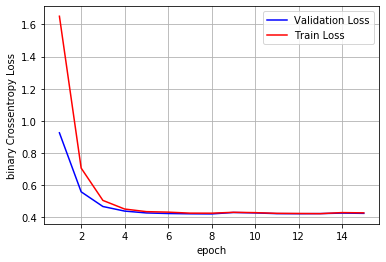

In [89]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('binary Crossentropy Loss')

# list of epoch numbers
x = list(range(1,16))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs


vy = history_2.history['val_loss']
ty = history_2.history['loss']
plt_dynamic(x, vy, ty, ax)

In [90]:
def plt_dynamic_auc(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation auc")
    ax.plot(x, ty, 'r', label="Train auc")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

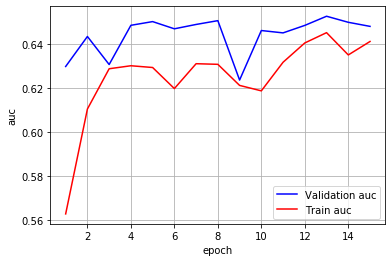

In [93]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('auc')

# list of epoch numbers
x = list(range(1,16))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs


vy = history_2.history['val_auroc']
ty = history_2.history['auroc']
plt_dynamic_auc(x, vy, ty, ax)

### Model 3 

In [27]:
vectorizer = CountVectorizer(binary=True)
vectorizer.fit(x_train['teacher_prefix'].values)
x_train_teacher_prefix = vectorizer.transform(x_train['teacher_prefix'].values)
x_cv_teacher_prefix = vectorizer.transform(x_cv['teacher_prefix'].values)
x_test_teacher_prefix = vectorizer.transform(x_test['teacher_prefix'].values)
teacher_prefix_f=vectorizer.get_feature_names()
print("After vectorizations of teacher_prefix")
print(x_train_teacher_prefix.shape, y_train.shape)
print(x_cv_teacher_prefix.shape, y_cv.shape)
print(x_test_teacher_prefix.shape, y_test.shape)
print(vectorizer.get_feature_names())

print("========================================================")

#vectorizer = CountVectorizer()
vectorizer.fit(x_train['school_state'].values)
x_train_state = vectorizer.transform(x_train['school_state'].values)
x_cv_state = vectorizer.transform(x_cv['school_state'].values)
x_test_state = vectorizer.transform(x_test['school_state'].values)
state_f=vectorizer.get_feature_names()
print("After vectorizations of school_state")
print(x_train_state.shape, y_train.shape)
print(x_cv_state.shape, y_cv.shape)
print(x_test_state.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("========================================================")

#vectorizer = CountVectorizer()
vectorizer.fit(['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2'])
x_train_grade = vectorizer.transform(x_train['project_grade_category'].values)
x_cv_grade = vectorizer.transform(x_cv['project_grade_category'].values)
x_test_grade = vectorizer.transform(x_test['project_grade_category'].values)
teacher_grade_f=vectorizer.get_feature_names()
print("After vectorizations of project_grade_category")
print(x_train_grade.shape, y_train.shape)
print(x_cv_grade.shape, y_cv.shape)
print(x_test_grade.shape, y_test.shape)
print(vectorizer.get_feature_names())

print("========================================================")

#vectorizer = CountVectorizer()
vectorizer.fit(x_train['clean_categories'].values)
x_train_cat = vectorizer.transform(x_train['clean_categories'].values)
x_cv_cat = vectorizer.transform(x_cv['clean_categories'].values)
x_test_cat = vectorizer.transform(x_test['clean_categories'].values)
teacher_cat_f=vectorizer.get_feature_names()
print("After vectorizations of clean_categories")
print(x_train_cat.shape, y_train.shape)
print(x_cv_cat.shape, y_cv.shape)
print(x_test_cat.shape, y_test.shape)
print(vectorizer.get_feature_names())

print("========================================================")

#vectorizer = CountVectorizer()
vectorizer.fit(x_train['clean_subcategories'].values)
x_train_scat = vectorizer.transform(x_train['clean_subcategories'].values)
x_cv_scat = vectorizer.transform(x_cv['clean_subcategories'].values)
x_test_scat = vectorizer.transform(x_test['clean_subcategories'].values)
teacher_scat_f=vectorizer.get_feature_names()
print("After vectorizations of clean_subcategories ")
print(x_train_scat.shape, y_train.shape)
print(x_cv_scat.shape, y_cv.shape)
print(x_test_scat.shape, y_test.shape)
print(vectorizer.get_feature_names())

print("========================================================")

After vectorizations of teacher_prefix
(69918, 5) (69918,)
(17480, 5) (17480,)
(21850, 5) (21850,)
['dr', 'mr', 'mrs', 'ms', 'teacher']
After vectorizations of school_state
(69918, 51) (69918,)
(17480, 51) (17480,)
(21850, 51) (21850,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']
After vectorizations of project_grade_category
(69918, 4) (69918,)
(17480, 4) (17480,)
(21850, 4) (21850,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']
After vectorizations of clean_categories
(69918, 9) (69918,)
(17480, 9) (17480,)
(21850, 9) (21850,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']
After vectorizations of clean_subcategori

In [28]:
input_train = np.concatenate((x_train['quantity'].values.reshape(-1,1),x_train['price'].values.reshape(-1,1),x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)), axis=1)
input_cv = np.concatenate((x_cv['quantity'].values.reshape(-1,1),x_cv['price'].values.reshape(-1,1),x_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)), axis=1)
input_test = np.concatenate((x_test['quantity'].values.reshape(-1,1),x_test['price'].values.reshape(-1,1),x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)), axis=1)

In [31]:
x_tr_rem = hstack((x_train_state, x_train_teacher_prefix, x_train_grade,x_train_scat,x_train_cat, input_train)).todense()
x_cv_rem = hstack(( x_cv_state, x_cv_teacher_prefix, x_cv_grade,x_cv_scat,x_cv_cat, input_cv)).todense()
x_te_rem = hstack((x_test_state, x_test_teacher_prefix, x_test_grade,x_test_scat,x_test_cat, input_test)).todense()
print("Final Data matrix")
print(x_tr_rem.shape, y_train.shape)
print(x_cv_rem.shape, y_cv.shape)
print(x_te_rem.shape, y_test.shape)
print("="*100)

Final Data matrix
(69918, 102) (69918,)
(17480, 102) (17480,)
(21850, 102) (21850,)


In [32]:
std_scr = StandardScaler().fit(x_tr_rem)
x_train_rem_std = std_scr.transform(x_tr_rem)
x_cv_rem_std = std_scr.transform(x_cv_rem)
x_test_rem_std = std_scr.transform(x_te_rem)

In [35]:
x_train_rem_std.shape

(69918, 102)

In [74]:
x_train_rem_reshape = np.stack(x_tr_rem)
x_cv_rem_reshape = np.stack(x_cv_rem)
x_test_rem_reshape = np.stack(x_te_rem)

In [76]:
x_tr_rem = np.array(x_train_rem_reshape).reshape(69918,102,1)
x_cv_rem = np.array(x_cv_rem_reshape).reshape(17480,102,1)
x_te_rem = np.array(x_test_rem_reshape).reshape(21850,102,1)

In [77]:
print(x_tr_rem.shape, x_cv_rem.shape, x_te_rem.shape)

(69918, 102, 1) (17480, 102, 1) (21850, 102, 1)


In [39]:
max_length=400

In [40]:
#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
def padded(encoded_docs):  
    max_length = 400
    padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
    return padded_docs

In [41]:
#https://stackoverflow.com/posts/51956230/revisions
t = Tokenizer()
t.fit_on_texts(x_train.clean_essay)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(x_train.clean_essay)
essay_padded_train = padded(encoded_docs)

In [42]:
encoded_docs = t.texts_to_sequences(x_cv.clean_essay)
essay_padded_cv = padded(encoded_docs)

In [43]:
encoded_docs = t.texts_to_sequences(x_test.clean_essay)
essay_padded_test = padded(encoded_docs)

In [44]:
print("encoded train data shape",essay_padded_train.shape)
print("encoded cv data shape",essay_padded_cv.shape)
print("encoded cv data shape",essay_padded_test.shape)

encoded train data shape (69918, 400)
encoded cv data shape (17480, 400)
encoded cv data shape (21850, 400)


In [45]:
embeddings_index = dict()
f = open('glove.6B.50d.txt', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [46]:
embedding_matrix = zeros((vocab_size, 50))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [47]:
print("embedding matrix shape",embedding_matrix.shape)

embedding matrix shape (47501, 50)


In [48]:
y_binary_train = to_categorical(y_train)
y_binary_cv = to_categorical(y_cv)
y_binary_test = to_categorical(y_test)

In [78]:
text_input = Input(shape=(400,), name = "text_input")
# max_length = 150 ---->max length of sentence

e1 = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=400)(text_input)
l1= LSTM(128,activation = "relu",dropout=0.5,kernel_regularizer=l2(0.001),kernel_initializer='glorot_normal',return_sequences=True,input_shape=(150,300))(e1)
f1= Flatten()(l1)

rem = Input(shape=(x_tr_rem.shape[1],1), name="rem")
rem_conv1 = Conv1D(128, 3,kernel_initializer='glorot_normal')(rem)
rem_conv2 =Conv1D(64, 3, activation='relu',kernel_initializer='glorot_normal' )(rem_conv1)
f2= Flatten()(rem_conv2)

x = concatenate([f1,f2])

x= Dense(32,kernel_regularizer=l2(0.001),kernel_initializer='glorot_normal')(x)
x= Dropout(0.5)(x)
x= Dense(16, activation='relu')(x)
x= Dropout(0.3)(x)
output=Dense(2, activation='softmax')(x)
model_3 = Model(inputs=[text_input,rem], outputs=output)
model_3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         (None, 400)          0                                            
__________________________________________________________________________________________________
rem (InputLayer)                (None, 102, 1)       0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 400, 50)      2375050     text_input[0][0]                 
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 100, 128)     512         rem[0][0]                        
__________________________________________________________________________________________________
lstm_5 (LS

In [57]:
#https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/
from keras.utils.vis_utils import plot_model
plot_model(model_3, to_file='model_2.png', show_shapes=True, show_layer_names=True)

<img src="model_2.png">

In [58]:
def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [59]:
batch_size=512

In [79]:
model_3.compile(optimizer=tf.train.AdamOptimizer(), loss='categorical_crossentropy',metrics=['accuracy', auroc])

In [80]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir= log_dir)

In [81]:
callbacks_list = [tensorboard]

In [82]:
history_3= model_3.fit({'text_input': essay_padded_train, 'rem':x_tr_rem},y_binary_train,
          epochs=15, batch_size=batch_size,verbose=1, validation_data=({'text_input': essay_padded_cv, 'rem': x_cv_rem},
          y_binary_cv),callbacks=callbacks_list)

W1028 18:52:49.455241 19492 deprecation.py:323] From c:\users\acer\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 69918 samples, validate on 17480 samples


W1028 18:52:52.907143 19492 deprecation_wrapper.py:119] From c:\users\acer\appdata\local\programs\python\python37\lib\site-packages\keras\callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W1028 18:52:52.907143 19492 deprecation_wrapper.py:119] From c:\users\acer\appdata\local\programs\python\python37\lib\site-packages\keras\callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/15
69918/69918 [==============================] - ETA: 29:36 - loss: 1.3349 - acc: 0.5703 - auroc: 0.44 - ETA: 22:24 - loss: 2.0543 - acc: 0.6904 - auroc: 0.47 - ETA: 20:07 - loss: 2.1640 - acc: 0.7435 - auroc: 0.48 - ETA: 19:34 - loss: 2.1664 - acc: 0.7725 - auroc: 0.48 - ETA: 19:36 - loss: 2.2587 - acc: 0.7824 - auroc: 0.49 - ETA: 19:55 - loss: 2.2786 - acc: 0.7933 - auroc: 0.48 - ETA: 20:29 - loss: 2.3032 - acc: 0.7999 - auroc: 0.47 - ETA: 21:04 - loss: 2.3236 - acc: 0.8040 - auroc: 0.48 - ETA: 21:41 - loss: 2.3674 - acc: 0.8047 - auroc: 0.48 - ETA: 22:18 - loss: 2.3918 - acc: 0.8053 - auroc: 0.48 - ETA: 22:48 - loss: 2.3796 - acc: 0.8074 - auroc: 0.48 - ETA: 23:23 - loss: 2.3855 - acc: 0.8084 - auroc: 0.48 - ETA: 23:56 - loss: 2.3604 - acc: 0.8110 - auroc: 0.48 - ETA: 24:28 - loss: 2.3479 - acc: 0.8111 - auroc: 0.48 - ETA: 24:59 - loss: 2.3211 - acc: 0.8126 - auroc: 0.48 - ETA: 25:27 - loss: 2.3017 - acc: 0.8119 - auroc: 0.48 - ETA: 25:54 - loss: 2.2682 - acc: 0.8114 - auro

69918/69918 [==============================] - ETA: 1:46:49 - loss: 0.4943 - acc: 0.8613 - auroc: 0.60 - ETA: 1:45:17 - loss: 0.5441 - acc: 0.8379 - auroc: 0.57 - ETA: 1:44:10 - loss: 0.5389 - acc: 0.8405 - auroc: 0.57 - ETA: 1:43:14 - loss: 0.5338 - acc: 0.8408 - auroc: 0.59 - ETA: 1:42:16 - loss: 0.5461 - acc: 0.8383 - auroc: 0.57 - ETA: 1:41:28 - loss: 0.5370 - acc: 0.8431 - auroc: 0.57 - ETA: 1:40:41 - loss: 0.5324 - acc: 0.8451 - auroc: 0.57 - ETA: 1:39:59 - loss: 0.5321 - acc: 0.8455 - auroc: 0.57 - ETA: 1:39:25 - loss: 0.5328 - acc: 0.8461 - auroc: 0.57 - ETA: 1:38:39 - loss: 0.5334 - acc: 0.8457 - auroc: 0.57 - ETA: 1:37:55 - loss: 0.5365 - acc: 0.8438 - auroc: 0.56 - ETA: 1:37:15 - loss: 0.5331 - acc: 0.8454 - auroc: 0.57 - ETA: 1:36:29 - loss: 0.5340 - acc: 0.8447 - auroc: 0.57 - ETA: 1:35:48 - loss: 0.5312 - acc: 0.8461 - auroc: 0.57 - ETA: 1:35:03 - loss: 0.5295 - acc: 0.8465 - auroc: 0.57 - ETA: 1:34:18 - loss: 0.5300 - acc: 0.8462 - auroc: 0.57 - ETA: 1:33:35 - loss: 0.53

69918/69918 [==============================] - ETA: 1:03:46 - loss: 0.5235 - acc: 0.8398 - auroc: 0.59 - ETA: 1:02:41 - loss: 0.5020 - acc: 0.8486 - auroc: 0.61 - ETA: 1:01:56 - loss: 0.5240 - acc: 0.8405 - auroc: 0.60 - ETA: 1:01:52 - loss: 0.5160 - acc: 0.8462 - auroc: 0.60 - ETA: 1:01:22 - loss: 0.5063 - acc: 0.8508 - auroc: 0.60 - ETA: 1:01:09 - loss: 0.5099 - acc: 0.8480 - auroc: 0.61 - ETA: 1:00:39 - loss: 0.5085 - acc: 0.8493 - auroc: 0.60 - ETA: 1:00:07 - loss: 0.5125 - acc: 0.8484 - auroc: 0.60 - ETA: 59:32 - loss: 0.5082 - acc: 0.8496 - auroc: 0.6077 - ETA: 59:08 - loss: 0.5077 - acc: 0.8498 - auroc: 0.60 - ETA: 58:38 - loss: 0.5068 - acc: 0.8514 - auroc: 0.60 - ETA: 58:08 - loss: 0.5062 - acc: 0.8503 - auroc: 0.60 - ETA: 57:39 - loss: 0.5046 - acc: 0.8501 - auroc: 0.61 - ETA: 57:08 - loss: 0.5061 - acc: 0.8488 - auroc: 0.61 - ETA: 56:39 - loss: 0.5058 - acc: 0.8486 - auroc: 0.61 - ETA: 56:13 - loss: 0.5046 - acc: 0.8490 - auroc: 0.61 - ETA: 55:44 - loss: 0.5039 - acc: 0.8491

69918/69918 [==============================] - ETA: 1:02:59 - loss: 0.5140 - acc: 0.8398 - auroc: 0.60 - ETA: 1:01:04 - loss: 0.4973 - acc: 0.8467 - auroc: 0.62 - ETA: 1:01:33 - loss: 0.4953 - acc: 0.8431 - auroc: 0.64 - ETA: 1:02:11 - loss: 0.4940 - acc: 0.8457 - auroc: 0.63 - ETA: 1:00:52 - loss: 0.4973 - acc: 0.8469 - auroc: 0.61 - ETA: 59:52 - loss: 0.4920 - acc: 0.8496 - auroc: 0.6231 - ETA: 58:54 - loss: 0.4894 - acc: 0.8513 - auroc: 0.62 - ETA: 58:06 - loss: 0.4919 - acc: 0.8484 - auroc: 0.63 - ETA: 57:27 - loss: 0.4959 - acc: 0.8461 - auroc: 0.63 - ETA: 56:45 - loss: 0.4906 - acc: 0.8490 - auroc: 0.63 - ETA: 56:08 - loss: 0.4891 - acc: 0.8493 - auroc: 0.63 - ETA: 55:32 - loss: 0.4876 - acc: 0.8496 - auroc: 0.64 - ETA: 54:57 - loss: 0.4875 - acc: 0.8496 - auroc: 0.64 - ETA: 54:27 - loss: 0.4874 - acc: 0.8497 - auroc: 0.64 - ETA: 55:37 - loss: 0.4842 - acc: 0.8518 - auroc: 0.64 - ETA: 57:44 - loss: 0.4840 - acc: 0.8524 - auroc: 0.64 - ETA: 59:29 - loss: 0.4843 - acc: 0.8519 - aur

69918/69918 [==============================] - ETA: 1:55:35 - loss: 0.5060 - acc: 0.8301 - auroc: 0.67 - ETA: 1:54:22 - loss: 0.4914 - acc: 0.8359 - auroc: 0.68 - ETA: 1:53:28 - loss: 0.4833 - acc: 0.8418 - auroc: 0.68 - ETA: 1:52:41 - loss: 0.4836 - acc: 0.8462 - auroc: 0.66 - ETA: 1:51:31 - loss: 0.4767 - acc: 0.8496 - auroc: 0.67 - ETA: 1:50:52 - loss: 0.4817 - acc: 0.8483 - auroc: 0.66 - ETA: 1:49:55 - loss: 0.4807 - acc: 0.8465 - auroc: 0.67 - ETA: 1:48:58 - loss: 0.4797 - acc: 0.8464 - auroc: 0.67 - ETA: 1:47:57 - loss: 0.4795 - acc: 0.8472 - auroc: 0.66 - ETA: 1:47:00 - loss: 0.4783 - acc: 0.8475 - auroc: 0.67 - ETA: 1:46:04 - loss: 0.4785 - acc: 0.8466 - auroc: 0.67 - ETA: 1:45:09 - loss: 0.4767 - acc: 0.8473 - auroc: 0.67 - ETA: 1:44:11 - loss: 0.4761 - acc: 0.8471 - auroc: 0.68 - ETA: 1:43:11 - loss: 0.4772 - acc: 0.8458 - auroc: 0.68 - ETA: 1:42:18 - loss: 0.4769 - acc: 0.8457 - auroc: 0.68 - ETA: 1:41:23 - loss: 0.4775 - acc: 0.8447 - auroc: 0.68 - ETA: 1:40:29 - loss: 0.47

69918/69918 [==============================] - ETA: 1:00:18 - loss: 0.4394 - acc: 0.8730 - auroc: 0.64 - ETA: 59:26 - loss: 0.4575 - acc: 0.8574 - auroc: 0.6772 - ETA: 59:00 - loss: 0.4630 - acc: 0.8509 - auroc: 0.68 - ETA: 58:27 - loss: 0.4501 - acc: 0.8599 - auroc: 0.68 - ETA: 58:00 - loss: 0.4582 - acc: 0.8566 - auroc: 0.68 - ETA: 57:32 - loss: 0.4618 - acc: 0.8542 - auroc: 0.68 - ETA: 57:08 - loss: 0.4670 - acc: 0.8516 - auroc: 0.67 - ETA: 56:52 - loss: 0.4697 - acc: 0.8501 - auroc: 0.67 - ETA: 56:23 - loss: 0.4706 - acc: 0.8477 - auroc: 0.68 - ETA: 55:54 - loss: 0.4776 - acc: 0.8439 - auroc: 0.67 - ETA: 55:24 - loss: 0.4756 - acc: 0.8461 - auroc: 0.67 - ETA: 54:58 - loss: 0.4733 - acc: 0.8472 - auroc: 0.68 - ETA: 54:32 - loss: 0.4754 - acc: 0.8463 - auroc: 0.68 - ETA: 54:11 - loss: 0.4752 - acc: 0.8458 - auroc: 0.68 - ETA: 53:48 - loss: 0.4747 - acc: 0.8460 - auroc: 0.68 - ETA: 53:18 - loss: 0.4737 - acc: 0.8467 - auroc: 0.68 - ETA: 52:49 - loss: 0.4705 - acc: 0.8486 - auroc: 0.68

69918/69918 [==============================] - ETA: 58:56 - loss: 0.5031 - acc: 0.8223 - auroc: 0.69 - ETA: 58:40 - loss: 0.4656 - acc: 0.8457 - auroc: 0.70 - ETA: 58:06 - loss: 0.4687 - acc: 0.8424 - auroc: 0.70 - ETA: 57:36 - loss: 0.4691 - acc: 0.8433 - auroc: 0.70 - ETA: 57:01 - loss: 0.4712 - acc: 0.8418 - auroc: 0.71 - ETA: 56:31 - loss: 0.4671 - acc: 0.8470 - auroc: 0.70 - ETA: 56:06 - loss: 0.4691 - acc: 0.8451 - auroc: 0.70 - ETA: 55:37 - loss: 0.4702 - acc: 0.8457 - auroc: 0.70 - ETA: 55:14 - loss: 0.4674 - acc: 0.8474 - auroc: 0.70 - ETA: 54:49 - loss: 0.4660 - acc: 0.8482 - auroc: 0.69 - ETA: 54:24 - loss: 0.4627 - acc: 0.8496 - auroc: 0.70 - ETA: 54:03 - loss: 0.4595 - acc: 0.8504 - auroc: 0.70 - ETA: 53:34 - loss: 0.4561 - acc: 0.8522 - auroc: 0.70 - ETA: 53:07 - loss: 0.4577 - acc: 0.8516 - auroc: 0.70 - ETA: 52:42 - loss: 0.4564 - acc: 0.8526 - auroc: 0.70 - ETA: 52:17 - loss: 0.4562 - acc: 0.8529 - auroc: 0.70 - ETA: 51:51 - loss: 0.4558 - acc: 0.8531 - auroc: 0.70 - E

69918/69918 [==============================] - ETA: 1:01:36 - loss: 0.4360 - acc: 0.8535 - auroc: 0.74 - ETA: 59:39 - loss: 0.4180 - acc: 0.8691 - auroc: 0.7165 - ETA: 58:58 - loss: 0.4289 - acc: 0.8646 - auroc: 0.71 - ETA: 58:17 - loss: 0.4394 - acc: 0.8608 - auroc: 0.71 - ETA: 57:36 - loss: 0.4392 - acc: 0.8609 - auroc: 0.71 - ETA: 57:04 - loss: 0.4471 - acc: 0.8564 - auroc: 0.71 - ETA: 56:36 - loss: 0.4514 - acc: 0.8527 - auroc: 0.71 - ETA: 56:04 - loss: 0.4568 - acc: 0.8503 - auroc: 0.71 - ETA: 55:36 - loss: 0.4571 - acc: 0.8498 - auroc: 0.71 - ETA: 55:10 - loss: 0.4574 - acc: 0.8496 - auroc: 0.71 - ETA: 54:44 - loss: 0.4607 - acc: 0.8468 - auroc: 0.71 - ETA: 54:16 - loss: 0.4631 - acc: 0.8447 - auroc: 0.71 - ETA: 53:50 - loss: 0.4614 - acc: 0.8465 - auroc: 0.71 - ETA: 53:22 - loss: 0.4625 - acc: 0.8465 - auroc: 0.71 - ETA: 52:54 - loss: 0.4600 - acc: 0.8479 - auroc: 0.71 - ETA: 52:26 - loss: 0.4612 - acc: 0.8477 - auroc: 0.71 - ETA: 52:00 - loss: 0.4611 - acc: 0.8473 - auroc: 0.71

69918/69918 [==============================] - ETA: 1:01:30 - loss: 0.4470 - acc: 0.8516 - auroc: 0.73 - ETA: 59:45 - loss: 0.4531 - acc: 0.8506 - auroc: 0.7296 - ETA: 58:48 - loss: 0.4628 - acc: 0.8535 - auroc: 0.70 - ETA: 58:09 - loss: 0.4561 - acc: 0.8521 - auroc: 0.72 - ETA: 57:38 - loss: 0.4462 - acc: 0.8559 - auroc: 0.73 - ETA: 57:06 - loss: 0.4457 - acc: 0.8564 - auroc: 0.73 - ETA: 56:38 - loss: 0.4454 - acc: 0.8538 - auroc: 0.74 - ETA: 56:04 - loss: 0.4502 - acc: 0.8508 - auroc: 0.73 - ETA: 55:32 - loss: 0.4476 - acc: 0.8535 - auroc: 0.73 - ETA: 55:02 - loss: 0.4453 - acc: 0.8541 - auroc: 0.73 - ETA: 54:35 - loss: 0.4479 - acc: 0.8519 - auroc: 0.73 - ETA: 54:11 - loss: 0.4549 - acc: 0.8486 - auroc: 0.72 - ETA: 53:44 - loss: 0.4568 - acc: 0.8481 - auroc: 0.72 - ETA: 53:19 - loss: 0.4606 - acc: 0.8463 - auroc: 0.72 - ETA: 52:52 - loss: 0.4607 - acc: 0.8465 - auroc: 0.72 - ETA: 52:25 - loss: 0.4615 - acc: 0.8453 - auroc: 0.72 - ETA: 51:57 - loss: 0.4597 - acc: 0.8457 - auroc: 0.72

69918/69918 [==============================] - ETA: 59:32 - loss: 0.4210 - acc: 0.8535 - auroc: 0.79 - ETA: 58:58 - loss: 0.4293 - acc: 0.8525 - auroc: 0.76 - ETA: 58:21 - loss: 0.4268 - acc: 0.8587 - auroc: 0.75 - ETA: 57:51 - loss: 0.4386 - acc: 0.8525 - auroc: 0.74 - ETA: 57:27 - loss: 0.4338 - acc: 0.8551 - auroc: 0.75 - ETA: 56:58 - loss: 0.4343 - acc: 0.8535 - auroc: 0.75 - ETA: 56:28 - loss: 0.4398 - acc: 0.8516 - auroc: 0.75 - ETA: 55:59 - loss: 0.4348 - acc: 0.8540 - auroc: 0.76 - ETA: 55:30 - loss: 0.4394 - acc: 0.8535 - auroc: 0.75 - ETA: 55:03 - loss: 0.4357 - acc: 0.8561 - auroc: 0.75 - ETA: 54:38 - loss: 0.4355 - acc: 0.8553 - auroc: 0.75 - ETA: 54:11 - loss: 0.4426 - acc: 0.8532 - auroc: 0.74 - ETA: 53:45 - loss: 0.4444 - acc: 0.8529 - auroc: 0.74 - ETA: 53:17 - loss: 0.4457 - acc: 0.8528 - auroc: 0.74 - ETA: 52:53 - loss: 0.4467 - acc: 0.8531 - auroc: 0.73 - ETA: 52:26 - loss: 0.4462 - acc: 0.8533 - auroc: 0.74 - ETA: 51:59 - loss: 0.4474 - acc: 0.8527 - auroc: 0.73 - E

69918/69918 [==============================] - ETA: 2:03:13 - loss: 0.5144 - acc: 0.8262 - auroc: 0.69 - ETA: 2:03:29 - loss: 0.4920 - acc: 0.8311 - auroc: 0.72 - ETA: 2:03:19 - loss: 0.4668 - acc: 0.8405 - auroc: 0.74 - ETA: 2:02:39 - loss: 0.4593 - acc: 0.8447 - auroc: 0.75 - ETA: 2:03:30 - loss: 0.4624 - acc: 0.8441 - auroc: 0.74 - ETA: 2:02:50 - loss: 0.4536 - acc: 0.8473 - auroc: 0.75 - ETA: 2:00:18 - loss: 0.4553 - acc: 0.8468 - auroc: 0.75 - ETA: 1:58:03 - loss: 0.4608 - acc: 0.8435 - auroc: 0.75 - ETA: 1:56:09 - loss: 0.4584 - acc: 0.8429 - auroc: 0.75 - ETA: 1:54:31 - loss: 0.4557 - acc: 0.8441 - auroc: 0.75 - ETA: 1:53:07 - loss: 0.4540 - acc: 0.8455 - auroc: 0.75 - ETA: 1:51:41 - loss: 0.4523 - acc: 0.8465 - auroc: 0.75 - ETA: 1:50:26 - loss: 0.4518 - acc: 0.8468 - auroc: 0.75 - ETA: 1:49:10 - loss: 0.4515 - acc: 0.8464 - auroc: 0.75 - ETA: 1:47:57 - loss: 0.4473 - acc: 0.8486 - auroc: 0.75 - ETA: 1:46:48 - loss: 0.4473 - acc: 0.8486 - auroc: 0.75 - ETA: 1:45:39 - loss: 0.44

69918/69918 [==============================] - ETA: 1:09:52 - loss: 0.3952 - acc: 0.8633 - auroc: 0.81 - ETA: 1:08:11 - loss: 0.4149 - acc: 0.8662 - auroc: 0.76 - ETA: 1:07:52 - loss: 0.4257 - acc: 0.8620 - auroc: 0.76 - ETA: 1:09:07 - loss: 0.4230 - acc: 0.8599 - auroc: 0.76 - ETA: 1:13:00 - loss: 0.4185 - acc: 0.8633 - auroc: 0.76 - ETA: 1:12:59 - loss: 0.4213 - acc: 0.8643 - auroc: 0.74 - ETA: 1:12:50 - loss: 0.4256 - acc: 0.8619 - auroc: 0.74 - ETA: 1:11:27 - loss: 0.4274 - acc: 0.8608 - auroc: 0.75 - ETA: 1:10:14 - loss: 0.4284 - acc: 0.8594 - auroc: 0.75 - ETA: 1:08:44 - loss: 0.4298 - acc: 0.8586 - auroc: 0.75 - ETA: 1:07:14 - loss: 0.4312 - acc: 0.8574 - auroc: 0.75 - ETA: 1:05:54 - loss: 0.4310 - acc: 0.8577 - auroc: 0.75 - ETA: 1:04:41 - loss: 0.4296 - acc: 0.8577 - auroc: 0.75 - ETA: 1:03:49 - loss: 0.4309 - acc: 0.8573 - auroc: 0.75 - ETA: 1:03:00 - loss: 0.4302 - acc: 0.8578 - auroc: 0.75 - ETA: 1:02:10 - loss: 0.4330 - acc: 0.8564 - auroc: 0.75 - ETA: 1:01:25 - loss: 0.43

69918/69918 [==============================] - ETA: 1:57:15 - loss: 0.4037 - acc: 0.8789 - auroc: 0.77 - ETA: 1:57:31 - loss: 0.4509 - acc: 0.8525 - auroc: 0.74 - ETA: 1:56:10 - loss: 0.4477 - acc: 0.8496 - auroc: 0.73 - ETA: 1:55:01 - loss: 0.4518 - acc: 0.8496 - auroc: 0.72 - ETA: 1:53:53 - loss: 0.4468 - acc: 0.8551 - auroc: 0.72 - ETA: 1:52:54 - loss: 0.4456 - acc: 0.8538 - auroc: 0.72 - ETA: 1:51:58 - loss: 0.4465 - acc: 0.8507 - auroc: 0.73 - ETA: 1:50:56 - loss: 0.4408 - acc: 0.8528 - auroc: 0.74 - ETA: 1:50:28 - loss: 0.4381 - acc: 0.8539 - auroc: 0.74 - ETA: 1:49:04 - loss: 0.4438 - acc: 0.8523 - auroc: 0.74 - ETA: 1:47:44 - loss: 0.4414 - acc: 0.8530 - auroc: 0.74 - ETA: 1:46:25 - loss: 0.4455 - acc: 0.8512 - auroc: 0.73 - ETA: 1:45:13 - loss: 0.4472 - acc: 0.8498 - auroc: 0.73 - ETA: 1:44:06 - loss: 0.4462 - acc: 0.8485 - auroc: 0.74 - ETA: 1:43:07 - loss: 0.4453 - acc: 0.8487 - auroc: 0.74 - ETA: 1:42:20 - loss: 0.4470 - acc: 0.8473 - auroc: 0.74 - ETA: 1:41:33 - loss: 0.44

69918/69918 [==============================] - ETA: 1:02:53 - loss: 0.4482 - acc: 0.8477 - auroc: 0.77 - ETA: 1:02:09 - loss: 0.4264 - acc: 0.8555 - auroc: 0.76 - ETA: 1:01:03 - loss: 0.4332 - acc: 0.8555 - auroc: 0.74 - ETA: 1:00:26 - loss: 0.4377 - acc: 0.8569 - auroc: 0.74 - ETA: 59:44 - loss: 0.4381 - acc: 0.8562 - auroc: 0.7492 - ETA: 59:09 - loss: 0.4355 - acc: 0.8594 - auroc: 0.74 - ETA: 58:41 - loss: 0.4363 - acc: 0.8580 - auroc: 0.74 - ETA: 58:14 - loss: 0.4340 - acc: 0.8599 - auroc: 0.74 - ETA: 57:47 - loss: 0.4324 - acc: 0.8587 - auroc: 0.75 - ETA: 57:15 - loss: 0.4275 - acc: 0.8609 - auroc: 0.75 - ETA: 56:46 - loss: 0.4271 - acc: 0.8603 - auroc: 0.75 - ETA: 56:13 - loss: 0.4275 - acc: 0.8589 - auroc: 0.76 - ETA: 55:43 - loss: 0.4325 - acc: 0.8553 - auroc: 0.76 - ETA: 55:12 - loss: 0.4333 - acc: 0.8544 - auroc: 0.76 - ETA: 54:45 - loss: 0.4326 - acc: 0.8551 - auroc: 0.76 - ETA: 54:19 - loss: 0.4327 - acc: 0.8549 - auroc: 0.76 - ETA: 53:57 - loss: 0.4321 - acc: 0.8551 - auroc

69918/69918 [==============================] - ETA: 1:06:38 - loss: 0.4062 - acc: 0.8652 - auroc: 0.82 - ETA: 1:07:25 - loss: 0.3984 - acc: 0.8691 - auroc: 0.81 - ETA: 1:06:09 - loss: 0.4045 - acc: 0.8678 - auroc: 0.79 - ETA: 1:06:30 - loss: 0.4157 - acc: 0.8604 - auroc: 0.79 - ETA: 1:05:45 - loss: 0.4164 - acc: 0.8578 - auroc: 0.78 - ETA: 1:04:46 - loss: 0.4181 - acc: 0.8597 - auroc: 0.77 - ETA: 1:04:17 - loss: 0.4186 - acc: 0.8585 - auroc: 0.77 - ETA: 1:03:16 - loss: 0.4223 - acc: 0.8564 - auroc: 0.77 - ETA: 1:02:43 - loss: 0.4237 - acc: 0.8561 - auroc: 0.77 - ETA: 1:02:03 - loss: 0.4264 - acc: 0.8541 - auroc: 0.77 - ETA: 1:01:27 - loss: 0.4252 - acc: 0.8546 - auroc: 0.78 - ETA: 1:00:58 - loss: 0.4270 - acc: 0.8540 - auroc: 0.77 - ETA: 1:00:23 - loss: 0.4287 - acc: 0.8522 - auroc: 0.77 - ETA: 1:00:04 - loss: 0.4282 - acc: 0.8527 - auroc: 0.77 - ETA: 59:37 - loss: 0.4268 - acc: 0.8540 - auroc: 0.7788 - ETA: 58:57 - loss: 0.4254 - acc: 0.8545 - auroc: 0.78 - ETA: 58:44 - loss: 0.4267 -

In [83]:
result = model_3.evaluate({'text_input': essay_padded_test, 'rem':x_te_rem},
          y_binary_test,batch_size=batch_size)

21850/21850 [==============================] - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 58s - ETA: 50 - ETA: 43 - ETA: 35 - ETA: 27 - ETA: 20 - ETA: 12 - ETA: 5 - 326s 15ms/step


In [90]:
print(result[0])
print(result[1])
print("val_auroc of test data :",result[2])

0.4503722227301696
0.8476887868307275
val_auroc of test data : 0.7465129057366187


In [85]:
%matplotlib notebook
%matplotlib inline

In [86]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

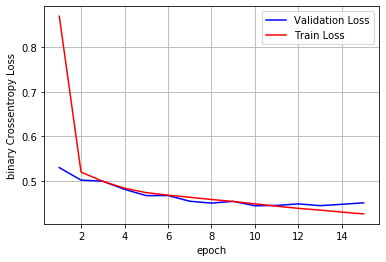

In [87]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('binary Crossentropy Loss')

# list of epoch numbers
x = list(range(1,16))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs


vy = history_3.history['val_loss']
ty = history_3.history['loss']
plt_dynamic(x, vy, ty, ax)

In [88]:
def plt_dynamic_auc(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation auc")
    ax.plot(x, ty, 'r', label="Train auc")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

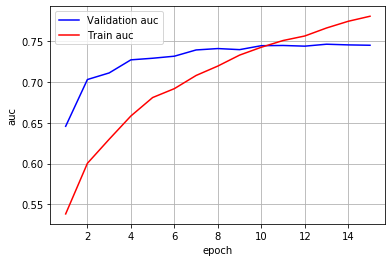

In [89]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('auc')

# list of epoch numbers
x = list(range(1,16))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs


vy = history_3.history['val_auroc']
ty = history_3.history['auroc']
plt_dynamic_auc(x, vy, ty, ax)

### Prettytable 

In [91]:
from prettytable import PrettyTable
pt=PrettyTable()
pt.field_names=["Model","test_auroc"]
pt.add_row(["Model_1","71.62"])
pt.add_row(["Model_2","69.58"])
pt.add_row(["Model_3","74.65"])

print(pt)

+---------+------------+
|  Model  | test_auroc |
+---------+------------+
| Model_1 |   71.62    |
| Model_2 |   69.58    |
| Model_3 |   74.65    |
+---------+------------+


### Conclusions 

1. We have build three models on Donors Choose data.
2. Added plots for Crossentropy loss and auroc.
3. In all the models, difference between validation loss and train loss is not much.
4. In third model, there is some overfitting after 10 epochs for auroc value.
5. Model three has highest test auroc value.
6. In first model we used larger input units for Dense layers and for second model we took smaller input units.